# SBI Training Workflow with sbi_delta

This notebook demonstrates how to set up, train, and evaluate a simulation-based inference (SBI) model for multiplexed fluorescence microscopy using the new `SBITrainer` class and the sbi_delta configuration and manager system.

We will:
- Set up experiment configuration (fluorophores, filters, priors, training parameters)
- Initialize the SBITrainer
- Set up the prior distribution
- Generate training data
- Train the SBI model
- Evaluate on validation data
- Analyze multiplexing capacity
- Save experiment results


In [1]:
# Section 1: Import Required Libraries
import os, sys
base_path = os.path.abspath("../..")
sys.path.append(base_path)  # Adjust path as needed
import numpy as np
import torch
from sbi_delta.config import BaseConfig, ExcitationConfig, FilterConfig, PriorConfig
from sbi_delta.spectra_manager import SpectraManager
from sbi_delta.excitation_manager import ExcitationManager
from sbi_delta.filter_bank import FilterBank
from sbi_delta.prior_manager import PriorManager
from sbi_delta.simulator.emission_simulator import EmissionSimulator
from sbi_delta.trainer import Trainer


/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [2]:
# Section 2: Define Experiment Configuration
# Define fluorophores, filters, and prior
fluorophore_names = ["JF479", "JF525", "JF552","JF608", "JFX650","JFX673"]

base_cfg = BaseConfig(
    min_wavelength=400,
    max_wavelength=750,
    wavelength_step=1,
    spectra_folder=os.path.join(base_path, "data/spectra_npz"),
    dye_names=fluorophore_names,
    bg_dye='AF_v1',
    photon_budget=1000,
)
exc_cfg = ExcitationConfig(excitation_mode="min_crosstalk")
filter_cfgs = [
    FilterConfig(start, stop, sharpness=1)
    for start, stop in zip([490, 530, 570, 620,680], [530, 570, 620, 680,740])
]
prior_cfg = PriorConfig(
    dirichlet_concentration=5.0,
    include_background_ratio=True,
    background_ratio_bounds=(0.05, 0.15),

)

spectra_mgr = SpectraManager(base_cfg)
spectra_mgr.load()
excitation_mgr = ExcitationManager(base_cfg, exc_cfg, spectra_mgr)
filter_bank = FilterBank(base_cfg, filter_cfgs)
prior_mgr = PriorManager(prior_cfg, base_cfg)
simulator = EmissionSimulator(
    spectra_manager=spectra_mgr,
    filter_bank=filter_bank,
    config=base_cfg,
    excitation_manager=excitation_mgr,
    prior_manager=prior_mgr,
)
print(simulator.prior_manager)

INFO:sbi_delta.spectra_manager:Initialized SpectraManager(folder=/groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz, dyes=['JF479', 'JF525', 'JF552', 'JF608', 'JFX650', 'JFX673'], bg_dye=AF_v1)
INFO:sbi_delta.spectra_manager:Starting load() of spectra
INFO:sbi_delta.spectra_manager:Found 22 .npz files in '/groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF479' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF479.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF479'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF525' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF525.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF525'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF552' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF552.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF552'
INFO:sb

PriorManager(n_fluorophores=6, dye_names=['JF479', 'JF525', 'JF552', 'JF608', 'JFX650', 'JFX673'], bg_dye='AF_v1', dirichlet_concentration=5.0, include_background_ratio=True, background_ratio_bounds=(0.05, 0.15))


array([<Axes: title={'center': 'JF479'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'JF525'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'JF552'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'JF608'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'JFX650'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'JFX673'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'Background Ratio'}, xlabel='Ratio', ylabel='Density'>],
      dtype=object)

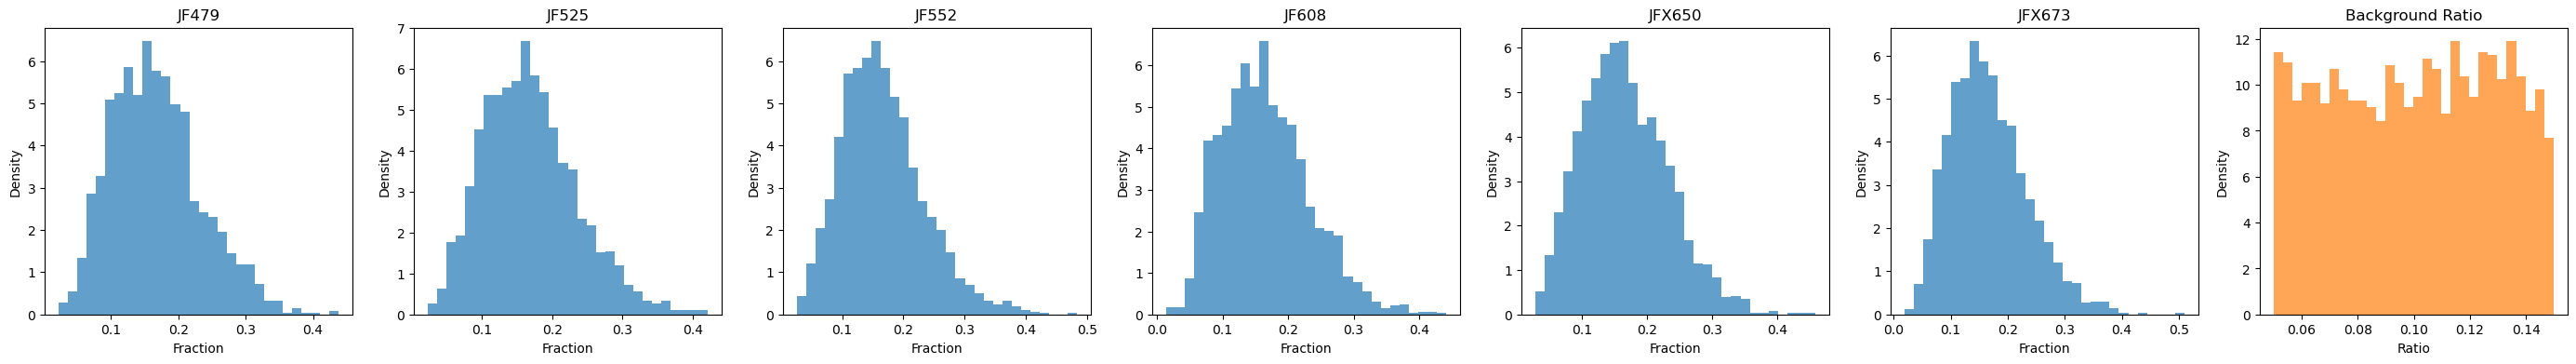

In [3]:
prior_mgr.visualize_joint_prior(2000)

In [4]:
excitation_mgr.excitation_wavelengths

array([477, 524, 554, 605, 646, 678])

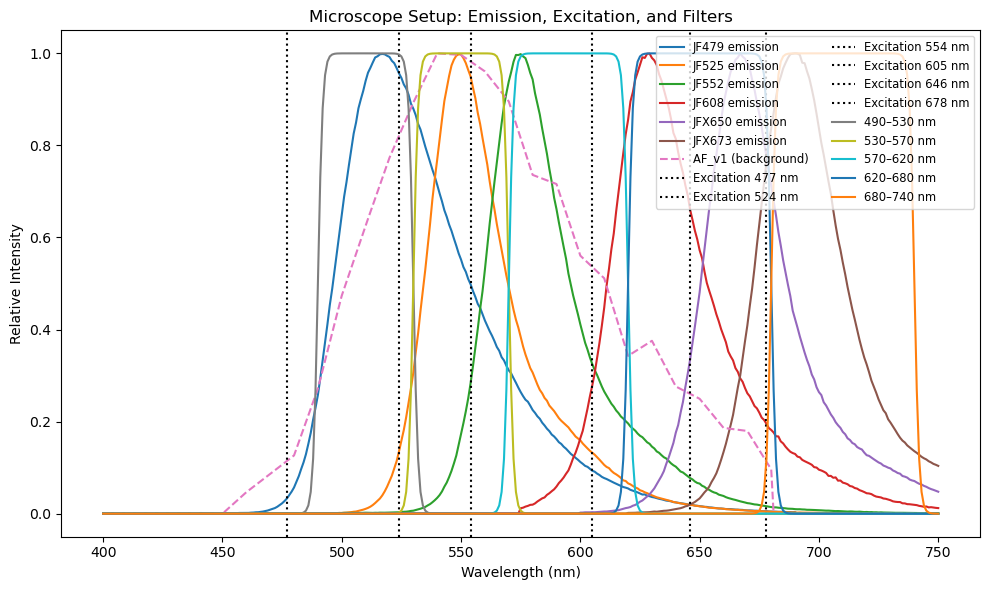

In [5]:
import matplotlib.pyplot as plt

# Plot emission spectra for all dyes and background
wavelengths = simulator.spectra_manager.wavelength_grid
plt.figure(figsize=(10, 6))

# Plot dye emission spectra
for dye in simulator.config.dye_names:
    em = simulator.spectra_manager.get_emission(dye)
    plt.plot(wavelengths, em, label=f"{dye} emission")

# Plot background emission if present
if hasattr(simulator.config, 'bg_dye') and simulator.config.bg_dye:
    bg_em = simulator.spectra_manager.get_emission(simulator.config.bg_dye)
    plt.plot(wavelengths, bg_em, label=f"{simulator.config.bg_dye} (background)", linestyle='--')

# Plot excitation lines
for exc in simulator.excitation_manager.excitation_wavelengths:
    plt.axvline(exc, color='k', linestyle=':', label=f"Excitation {exc} nm")
ax = plt.gca()
# Plot filter regions
simulator.filter_bank.plot_all_filters(ax=ax)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Intensity")
plt.title("Microscope Setup: Emission, Excitation, and Filters")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

In [6]:
# Section 3: Initialize Trainer with Simulator
trainer = Trainer(simulator, n_train=100000, n_val=10000, save_dir="sbi_training_demo_results")
print("Trainer prior:", trainer.prior)
posterior = trainer.train()
print("Posterior trained.")

Trainer prior: JointPrior()
 Neural network successfully converged after 101 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 101
        Best validation performance: -23.6842
        -------------------------
        
Posterior trained.


/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(


In [7]:
# Section 7: Evaluate Model on Validation Data
r2_scores, rmse_scores, rmse= trainer.validate()
print(f"Validation mean R^2: {np.mean(r2_scores):.3f}, RMSE: {rmse:.4f}")


Validating: 100%|██████████| 10000/10000 [04:17<00:00, 38.83it/s]


Validation mean R^2: 0.917, RMSE: 0.0164
Validation mean R^2: 0.917, RMSE: 0.0164


## Visualize Prediction Quality and Error Distributions
Explore model performance using the new plotting utilities in the Trainer class.

array([<Axes: title={'center': 'JF479'}, xlabel='True JF479', ylabel='Predicted JF479'>,
       <Axes: title={'center': 'JF525'}, xlabel='True JF525', ylabel='Predicted JF525'>,
       <Axes: title={'center': 'JF552'}, xlabel='True JF552', ylabel='Predicted JF552'>,
       <Axes: title={'center': 'JF608'}, xlabel='True JF608', ylabel='Predicted JF608'>,
       <Axes: title={'center': 'JFX650'}, xlabel='True JFX650', ylabel='Predicted JFX650'>,
       <Axes: title={'center': 'JFX673'}, xlabel='True JFX673', ylabel='Predicted JFX673'>,
       <Axes: title={'center': 'AF_v1'}, xlabel='True AF_v1', ylabel='Predicted AF_v1'>],
      dtype=object)

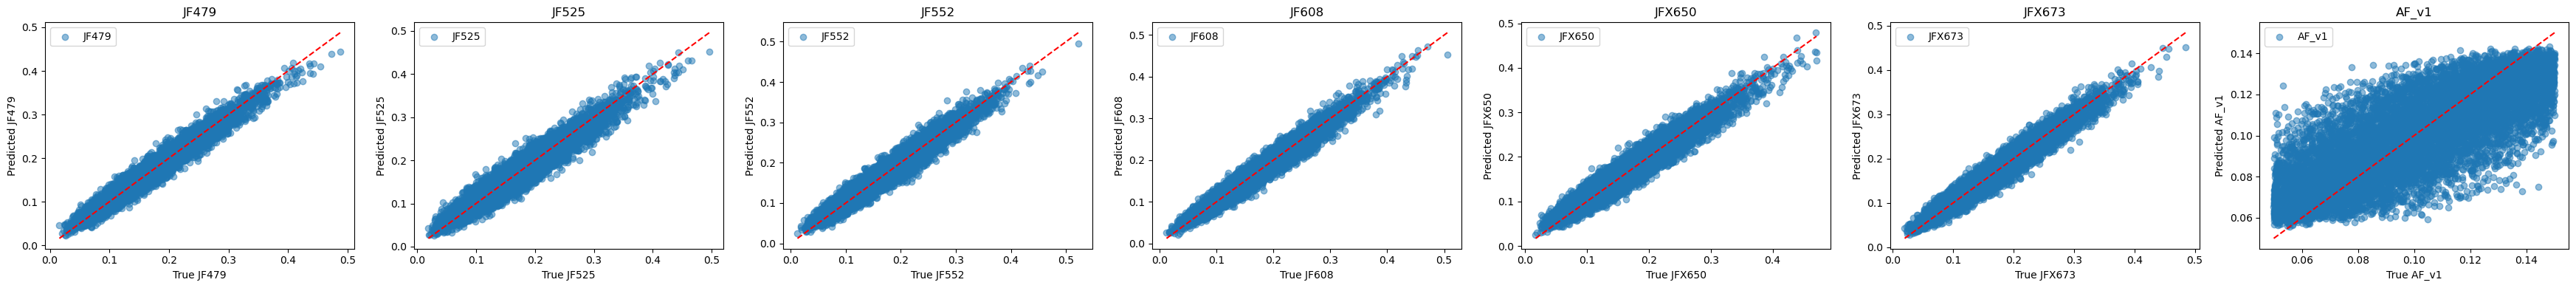

In [8]:
# Scatter plot: predicted vs true parameters for all validation examples
trainer.plot_pred_vs_true()

array([<Axes: title={'center': 'JF479 Error'}, xlabel='Error (True - Pred) JF479', ylabel='Count'>,
       <Axes: title={'center': 'JF525 Error'}, xlabel='Error (True - Pred) JF525', ylabel='Count'>,
       <Axes: title={'center': 'JF552 Error'}, xlabel='Error (True - Pred) JF552', ylabel='Count'>,
       <Axes: title={'center': 'JF608 Error'}, xlabel='Error (True - Pred) JF608', ylabel='Count'>,
       <Axes: title={'center': 'JFX650 Error'}, xlabel='Error (True - Pred) JFX650', ylabel='Count'>,
       <Axes: title={'center': 'JFX673 Error'}, xlabel='Error (True - Pred) JFX673', ylabel='Count'>,
       <Axes: title={'center': 'AF_v1 Error'}, xlabel='Error (True - Pred) AF_v1', ylabel='Count'>],
      dtype=object)

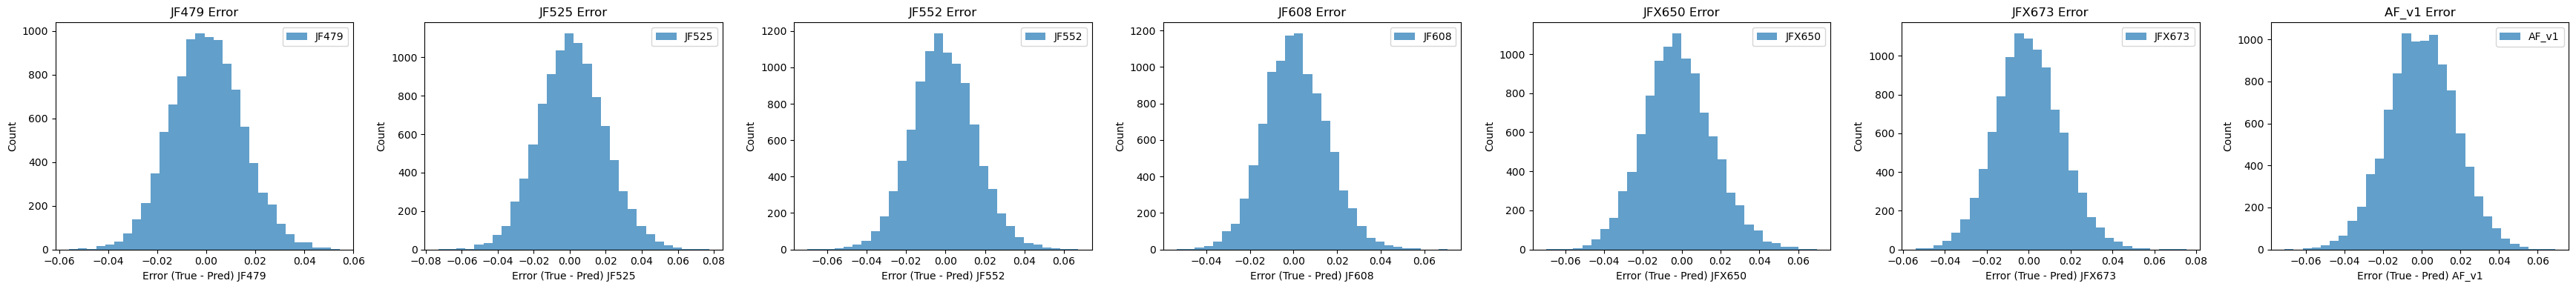

In [9]:
# Histograms of errors (true - predicted) for each parameter
trainer.plot_error_histograms()

array([<Axes: title={'center': 'Per-example R^2'}, xlabel='R^2 Score', ylabel='Count'>,
       <Axes: title={'center': 'Per-example RMSE'}, xlabel='RMSE', ylabel='Count'>],
      dtype=object)

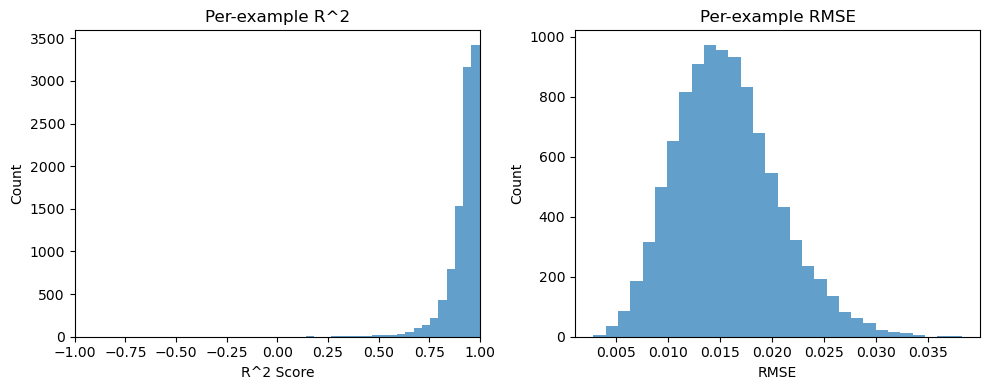

In [10]:
# Histograms of per-example R² and RMSE scores
trainer.plot_r2_rmse_distributions()

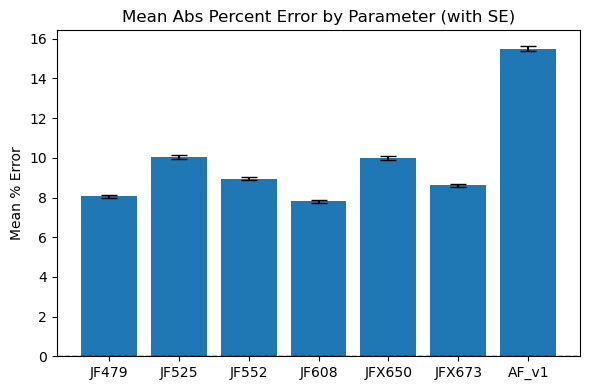

In [11]:
# Bar plot: mean percent error for each dye/background parameter with error bars (std)
import numpy as np
import matplotlib.pyplot as plt

val_theta = trainer.results['val_theta'].numpy()
pred_theta = trainer.results['pred_theta']

# Avoid division by zero: add small epsilon
epsilon = 1e-8
percent_errors = np.abs((pred_theta - val_theta) / (val_theta + epsilon) * 100)
mean_percent_error = np.mean(percent_errors, axis=0)
std_percent_error = np.std(percent_errors, axis=0)/ np.sqrt(percent_errors.shape[0])  # Standard error of the mean

# Get dye/background names
names = list(trainer.simulator.config.dye_names)
if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
    names = names + [trainer.simulator.config.bg_dye]
if len(names) < mean_percent_error.shape[0]:
    names += [f'Param {i+1}' for i in range(len(names), mean_percent_error.shape[0])]

plt.figure(figsize=(6, 4))
plt.bar(names, mean_percent_error, yerr=std_percent_error, capsize=6)
plt.ylabel('Mean % Error')
plt.title('Mean Abs Percent Error by Parameter (with SE)')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


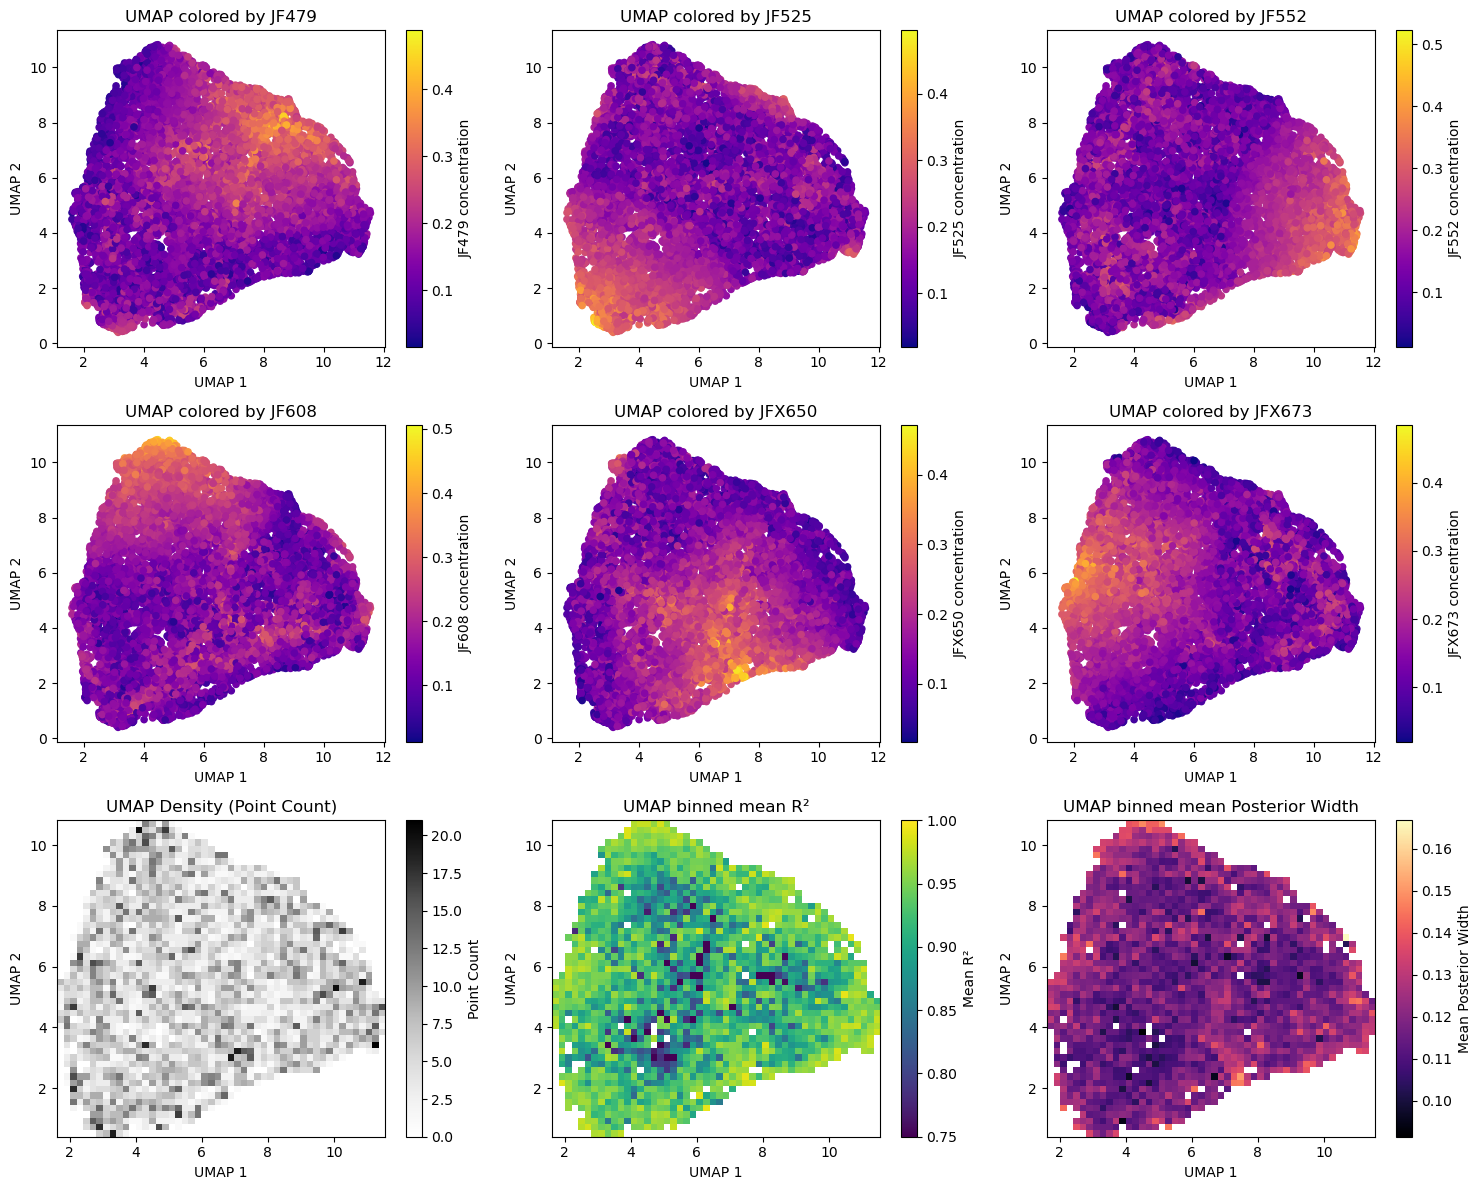

In [12]:
# UMAP subplots: color by each dye concentration, and binned mean for density, mean R², and mean posterior width
import numpy as np
import matplotlib.pyplot as plt
try:
    from umap import UMAP
except ImportError:
    from umap import umap_ as UMAP  # fallback if needed

n_dyes = len(trainer.simulator.config.dye_names)
names = list(trainer.simulator.config.dye_names)
concs = val_theta[:, :n_dyes]
proj = UMAP(n_components=2, random_state=0).fit_transform(concs)

ncols = 3
nrows = int(np.ceil((n_dyes + 3) / ncols))  # +3 for density, mean R², mean width
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

# Plot each dye concentration
for i, dye in enumerate(names):
    sc = axes[i].scatter(proj[:, 0], proj[:, 1], c=concs[:, i], cmap='plasma', s=20)
    cbar = plt.colorbar(sc, ax=axes[i])
    cbar.set_label(f'{dye} concentration')
    axes[i].set_title(f'UMAP colored by {dye}')
    axes[i].set_xlabel('UMAP 1')
    axes[i].set_ylabel('UMAP 2')

# Define bins for 2D histograms
bins = 50
xedges = np.linspace(proj[:, 0].min(), proj[:, 0].max(), bins+1)
yedges = np.linspace(proj[:, 1].min(), proj[:, 1].max(), bins+1)
X, Y = np.meshgrid(0.5*(xedges[:-1]+xedges[1:]), 0.5*(yedges[:-1]+yedges[1:]))

# Density (point count) map using 2D histogram
hist, _, _ = np.histogram2d(proj[:, 0], proj[:, 1], bins=[xedges, yedges])
ax_density = axes[n_dyes]
pcm = ax_density.pcolormesh(X, Y, hist.T, cmap='Greys')
cbar = plt.colorbar(pcm, ax=ax_density)
cbar.set_label('Point Count')
ax_density.set_title('UMAP Density (Point Count)')
ax_density.set_xlabel('UMAP 1')
ax_density.set_ylabel('UMAP 2')

# Binned mean R² per bin
if 'r2_scores' in trainer.results:
    r2_scores = np.array(trainer.results['r2_scores'])
    mean_r2 = np.full((bins, bins), np.nan)
    for i in range(bins):
        for j in range(bins):
            mask = (proj[:, 0] >= xedges[i]) & (proj[:, 0] < xedges[i+1]) & (proj[:, 1] >= yedges[j]) & (proj[:, 1] < yedges[j+1])
            if np.any(mask):
                mean_r2[i, j] = np.mean(r2_scores[mask])
    ax_r2 = axes[n_dyes+1]
    im_r2 = ax_r2.pcolormesh(X, Y, mean_r2.T, cmap='viridis', shading='auto')
    cbar = plt.colorbar(im_r2, ax=ax_r2)
    cbar.set_label('Mean R²')
    ax_r2.set_title('UMAP binned mean R²')
    ax_r2.set_xlabel('UMAP 1')
    ax_r2.set_ylabel('UMAP 2')
    im_r2.set_clim([0.75, 1])  # Set color limits for R²

# Binned mean posterior width per bin
if 'posterior_width' in trainer.results:
    posterior_width = trainer.results['posterior_width']
    mean_width = posterior_width.mean(axis=1)
    mean_width_bin = np.full((bins, bins), np.nan)
    for i in range(bins):
        for j in range(bins):
            mask = (proj[:, 0] >= xedges[i]) & (proj[:, 0] < xedges[i+1]) & (proj[:, 1] >= yedges[j]) & (proj[:, 1] < yedges[j+1])
            if np.any(mask):
                mean_width_bin[i, j] = np.mean(mean_width[mask])
    ax_width = axes[n_dyes+2]
    im_width = ax_width.pcolormesh(X, Y, mean_width_bin.T, cmap='magma', shading='auto')
    cbar = plt.colorbar(im_width, ax=ax_width)
    cbar.set_label('Mean Posterior Width')
    ax_width.set_title('UMAP binned mean Posterior Width')
    ax_width.set_xlabel('UMAP 1')
    ax_width.set_ylabel('UMAP 2')

# Hide unused subplots
for j in range(n_dyes+3, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

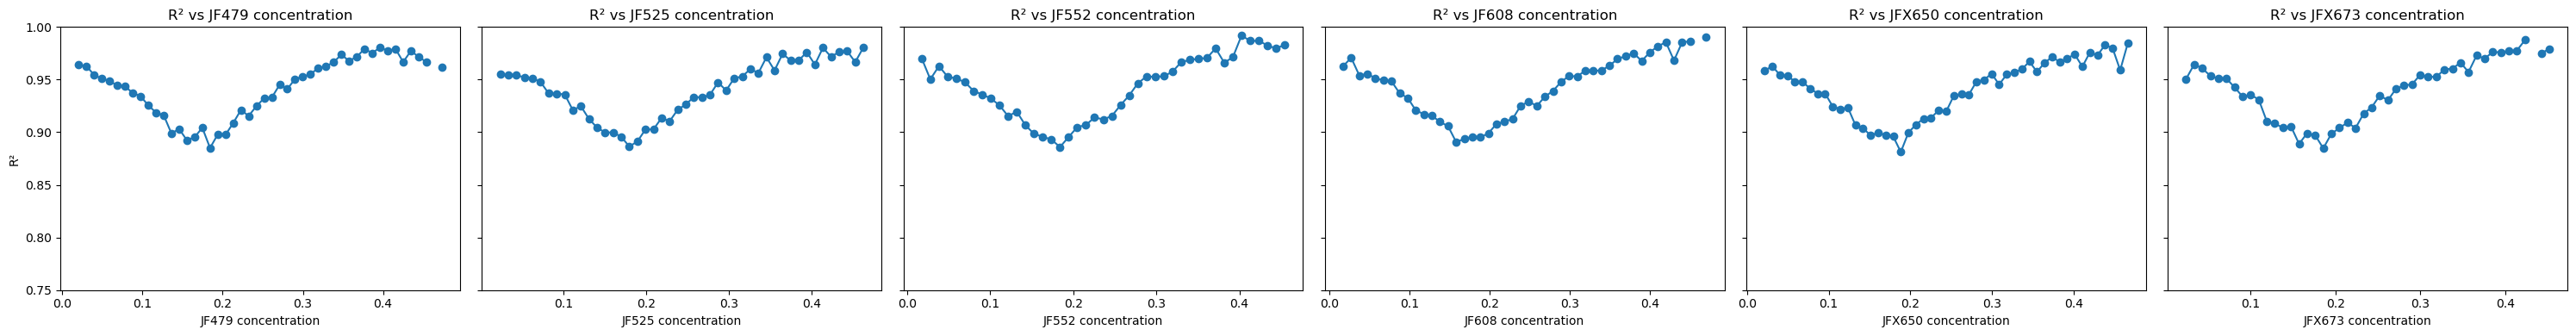

In [13]:
# Plot R² as a function of concentration for each dye
import numpy as np
import matplotlib.pyplot as plt

n_dyes = len(trainer.simulator.config.dye_names)
names = list(trainer.simulator.config.dye_names)
concs = val_theta[:, :n_dyes]
r2_scores = np.array(trainer.results['r2_scores'])

fig, axes = plt.subplots(1, n_dyes, figsize=(5*n_dyes, 4), sharey=True)
if n_dyes == 1:
    axes = [axes]

for i, dye in enumerate(names):
    # Bin concentrations for smoother curves
    bins = np.linspace(concs[:, i].min(), concs[:, i].max(), 50)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    inds = np.digitize(concs[:, i], bins) - 1
    mean_r2 = [np.mean(r2_scores[inds == j]) if np.any(inds == j) else np.nan for j in range(len(bin_centers))]
    axes[i].plot(bin_centers, mean_r2, marker='o')
    axes[i].set_xlabel(f'{dye} concentration')
    axes[i].set_title(f'R² vs {dye} concentration')
    axes[i].set_ylim(.75, 1)
axes[0].set_ylabel('R²')
plt.tight_layout()
plt.show()

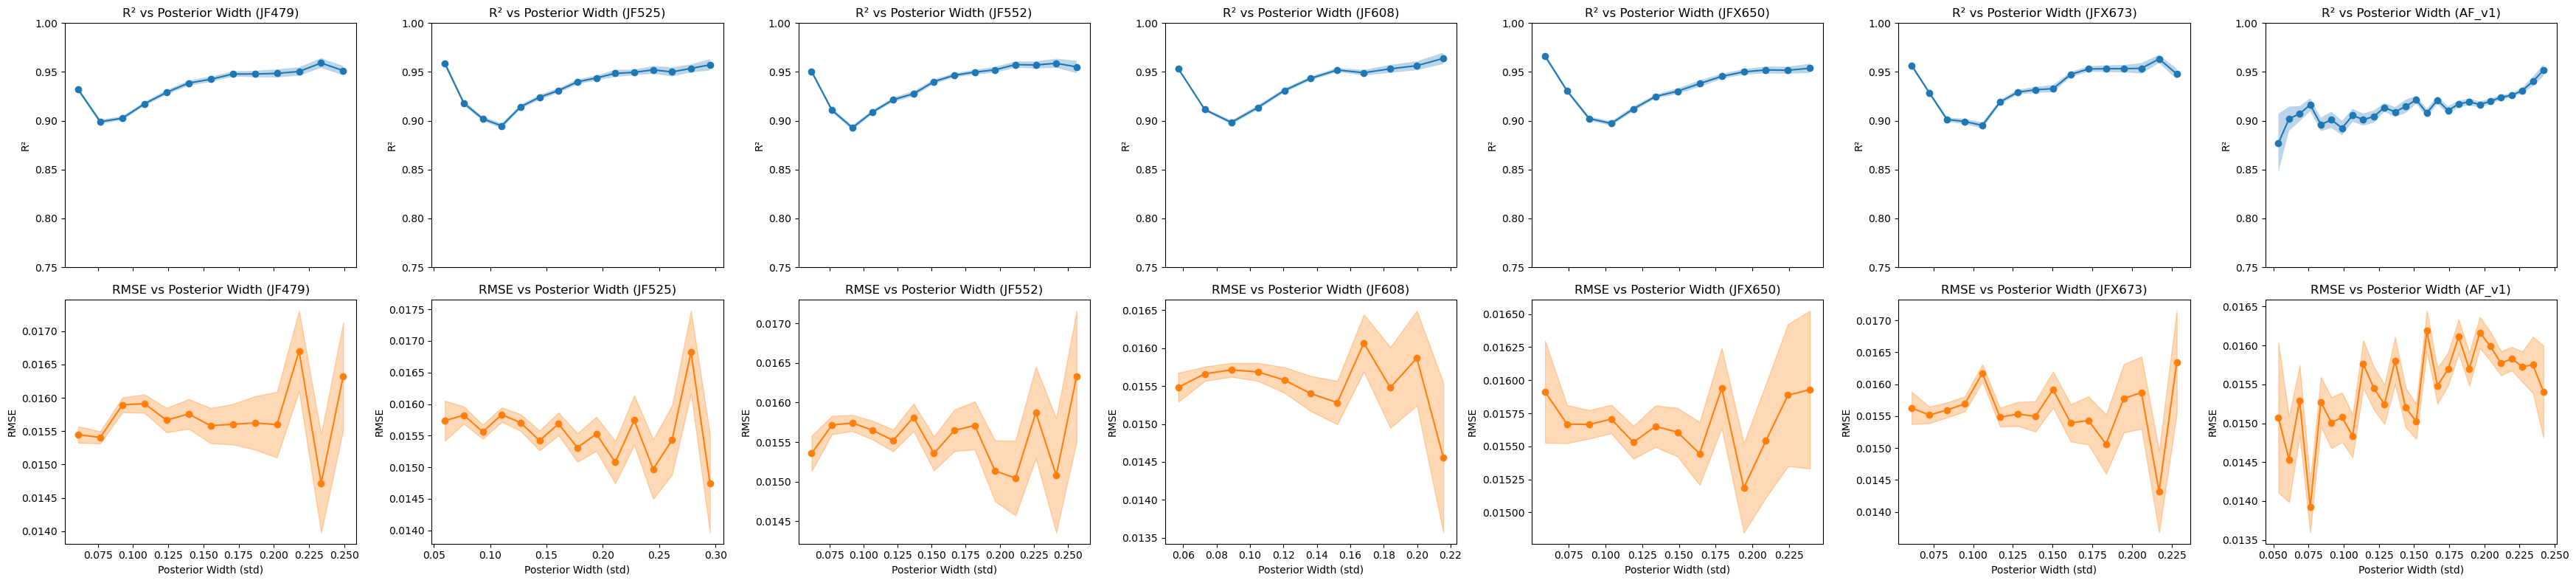

In [14]:
# Plot R² and RMSE as a function of posterior width for each parameter, with SEM shading and min count filter
import numpy as np
import matplotlib.pyplot as plt

posterior_width = trainer.results['posterior_width']  # shape: (n_val, n_params)
r2_scores = np.array(trainer.results['r2_scores'])
rmse_scores = np.array(trainer.results['rmse_scores'])
names = list(trainer.simulator.config.dye_names)
if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
    names = names + [trainer.simulator.config.bg_dye]
n_params = posterior_width.shape[1]
if len(names) < n_params:
    names += [f'Param {i+1}' for i in range(len(names), n_params)]

fig, axes = plt.subplots(2, n_params, figsize=(5*n_params, 8), sharex='col')
if n_params == 1:
    axes = np.array([[axes[0]], [axes[1]]])

min_count = 30  # Minimum number of samples per bin

for i in range(n_params):
    # Bin posterior width for smoother curves
    bins = np.linspace(posterior_width[:, i].min(), posterior_width[:, i].max(), 30)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    inds = np.digitize(posterior_width[:, i], bins) - 1
    mean_r2, sem_r2, mean_rmse, sem_rmse = [], [], [], []
    for j in range(len(bin_centers)):
        mask = inds == j
        count = np.sum(mask)
        if count >= min_count:
            mean_r2.append(np.mean(r2_scores[mask]))
            sem_r2.append(np.std(r2_scores[mask]) / np.sqrt(count))
            mean_rmse.append(np.mean(rmse_scores[mask]))
            sem_rmse.append(np.std(rmse_scores[mask]) / np.sqrt(count))
        else:
            mean_r2.append(np.nan)
            sem_r2.append(np.nan)
            mean_rmse.append(np.nan)
            sem_rmse.append(np.nan)
    mean_r2 = np.array(mean_r2)
    sem_r2 = np.array(sem_r2)
    mean_rmse = np.array(mean_rmse)
    sem_rmse = np.array(sem_rmse)
    # R² plot with SEM shading
    axes[0, i].plot(bin_centers, mean_r2, marker='o', label='Mean R²')
    axes[0, i].fill_between(bin_centers, mean_r2 - sem_r2, mean_r2 + sem_r2, alpha=0.3, label='SEM')
    axes[0, i].set_title(f'R² vs Posterior Width ({names[i]})')
    axes[0, i].set_ylabel('R²')
    axes[0, i].set_ylim(.75, 1)
    # RMSE plot with SEM shading
    axes[1, i].plot(bin_centers, mean_rmse, marker='o', color='C1', label='Mean RMSE')
    axes[1, i].fill_between(bin_centers, mean_rmse - sem_rmse, mean_rmse + sem_rmse, color='C1', alpha=0.3, label='SEM')
    axes[1, i].set_title(f'RMSE vs Posterior Width ({names[i]})')
    axes[1, i].set_xlabel('Posterior Width (std)')
    axes[1, i].set_ylabel('RMSE')
plt.tight_layout()
plt.show()

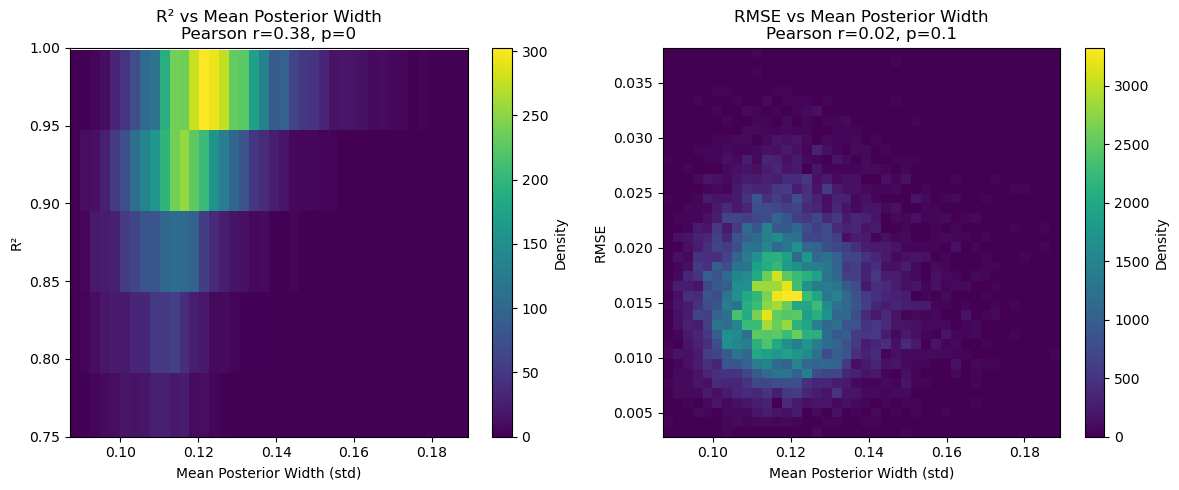

In [15]:
# Correlation between mean posterior width and R²/RMSE across all samples (2D density histograms)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

posterior_width = trainer.results['posterior_width']  # shape: (n_val, n_params)
r2_scores = np.array(trainer.results['r2_scores'])
rmse_scores = np.array(trainer.results['rmse_scores'])

mean_width = posterior_width.mean(axis=1)

# Compute Pearson correlation
corr_r2, pval_r2 = pearsonr(mean_width, r2_scores)
corr_rmse, pval_rmse = pearsonr(mean_width, rmse_scores)

plt.figure(figsize=(12, 5))

# 2D histogram for R²
plt.subplot(1, 2, 1)
h1 = plt.hist2d(mean_width, r2_scores, bins=40, cmap='viridis', density=True)
plt.colorbar(h1[3], label='Density')
plt.xlabel('Mean Posterior Width (std)')
plt.ylabel('R²')
plt.title(f'R² vs Mean Posterior Width\nPearson r={corr_r2:.2f}, p={pval_r2:.2g}')
# Improved ylim: fit to data with margin
r2_min, r2_max = np.nanmin(r2_scores), np.nanmax(r2_scores)
r2_margin = 0.05 * (r2_max - r2_min)
plt.ylim(0.75,1)

# 2D histogram for RMSE
plt.subplot(1, 2, 2)
h2 = plt.hist2d(mean_width, rmse_scores, bins=40, cmap='viridis', density=True)
plt.colorbar(h2[3], label='Density')
plt.xlabel('Mean Posterior Width (std)')
plt.ylabel('RMSE')
plt.title(f'RMSE vs Mean Posterior Width\nPearson r={corr_rmse:.2f}, p={pval_rmse:.2g}')
plt.tight_layout()
plt.show()

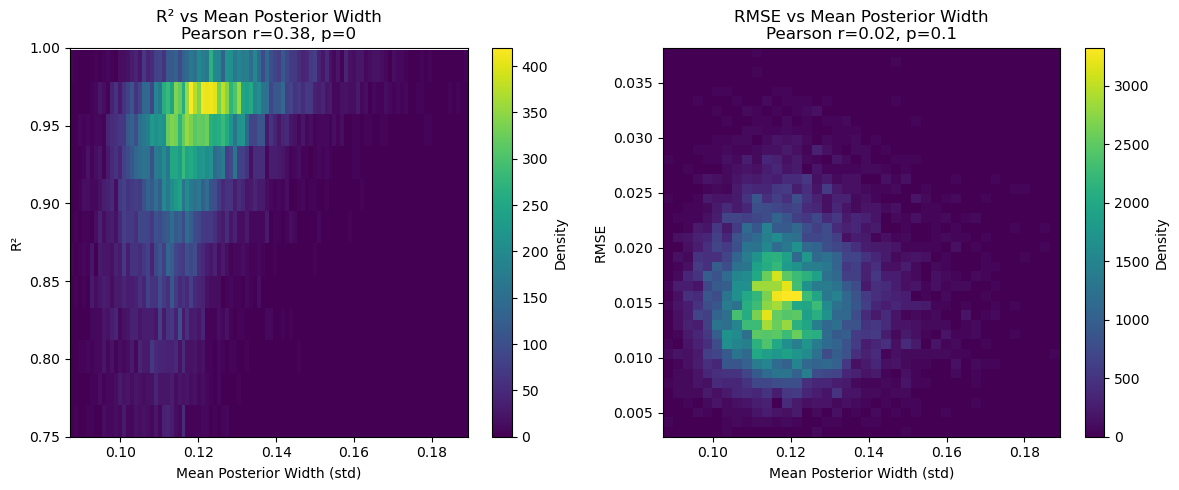

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

posterior_width = trainer.results['posterior_width']  # shape: (n_val, n_params)
r2_scores = np.array(trainer.results['r2_scores'])
rmse_scores = np.array(trainer.results['rmse_scores'])

mean_width = posterior_width.mean(axis=1)

# Compute Pearson correlation
corr_r2, pval_r2 = pearsonr(mean_width, r2_scores)
corr_rmse, pval_rmse = pearsonr(mean_width, rmse_scores)

plt.figure(figsize=(12, 5))

# 2D histogram for R²
plt.subplot(1, 2, 1)
h1 = plt.hist2d(mean_width, r2_scores, bins=100, cmap='viridis', density=True)
plt.colorbar(h1[3], label='Density')
plt.xlabel('Mean Posterior Width (std)')
plt.ylabel('R²')
plt.title(f'R² vs Mean Posterior Width\nPearson r={corr_r2:.2f}, p={pval_r2:.2g}')
# Improved ylim: fit to data with margin
r2_min, r2_max = np.nanmin(r2_scores), np.nanmax(r2_scores)
r2_margin = 0.05 * (r2_max - r2_min)
plt.ylim(0.75, 1)

# 2D histogram for RMSE
plt.subplot(1, 2, 2)
h2 = plt.hist2d(mean_width, rmse_scores, bins=40, cmap='viridis', density=True)
plt.colorbar(h2[3], label='Density')
plt.xlabel('Mean Posterior Width (std)')
plt.ylabel('RMSE')
plt.title(f'RMSE vs Mean Posterior Width\nPearson r={corr_rmse:.2f}, p={pval_rmse:.2g}')
plt.tight_layout()
plt.show()

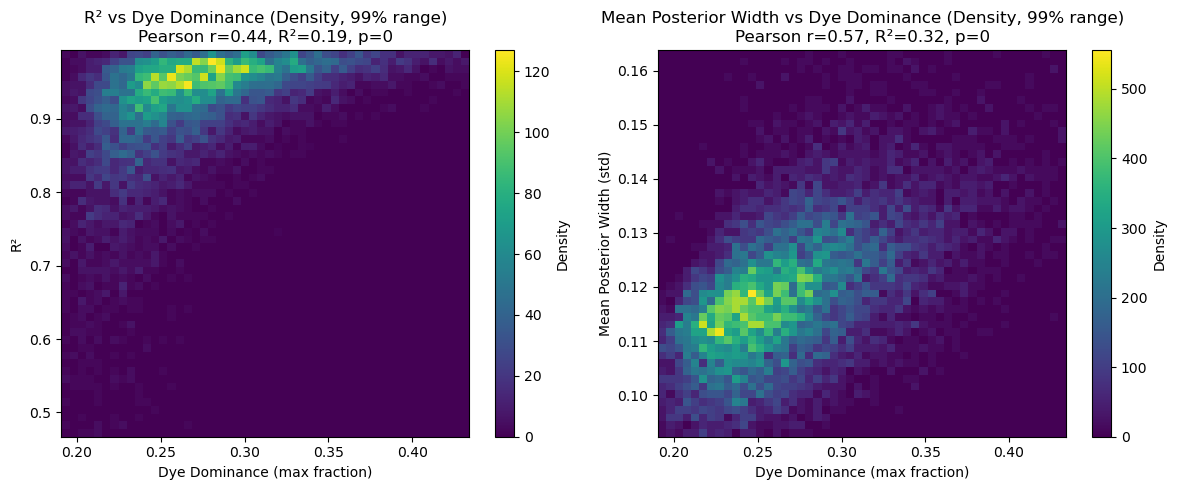

In [24]:
# Plot: Dye dominance (max fraction) vs R² and vs mean posterior width as 2D density plots with bins covering 99% of the data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate dye dominance (max fraction of any dye in each sample)
n_dyes = len(trainer.simulator.config.dye_names)
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']
dye_fractions = val_theta[:, :n_dyes] / np.clip(val_theta[:, :n_dyes].sum(axis=1, keepdims=True), 1e-8, None)
dominance = dye_fractions.max(axis=1)

# Get R² and mean posterior width
r2_scores = np.array(trainer.results['r2_scores'])
posterior_width = trainer.results['posterior_width']
mean_width = posterior_width.mean(axis=1)

# Compute 0.5th and 99.5th percentiles for all axes
x_min, x_max = np.percentile(dominance, [0.5, 99.5])
y1_min, y1_max = np.percentile(r2_scores, [0.5, 99.5])
y2_min, y2_max = np.percentile(mean_width, [0.5, 99.5])

# Compute correlations
corr_r2, pval_r2 = pearsonr(dominance, r2_scores)
r2_r2 = corr_r2 ** 2
corr_width, pval_width = pearsonr(dominance, mean_width)
r2_width = corr_width ** 2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Dominance vs R² (density, 99% range)
h1 = axes[0].hist2d(dominance, r2_scores, bins=[50, 50], range=[[x_min, x_max], [y1_min, y1_max]], cmap='viridis', density=True)
plt.colorbar(h1[3], ax=axes[0], label='Density')
axes[0].set_xlabel('Dye Dominance (max fraction)')
axes[0].set_ylabel('R²')
axes[0].set_title(f'R² vs Dye Dominance (Density, 99% range)\nPearson r={corr_r2:.2f}, R²={r2_r2:.2f}, p={pval_r2:.2g}')
axes[0].set_ylim(y1_min, y1_max)

# Dominance vs mean posterior width (density, 99% range)
h2 = axes[1].hist2d(dominance, mean_width, bins=[50, 50], range=[[x_min, x_max], [y2_min, y2_max]], cmap='viridis', density=True)
plt.colorbar(h2[3], ax=axes[1], label='Density')
axes[1].set_xlabel('Dye Dominance (max fraction)')
axes[1].set_ylabel('Mean Posterior Width (std)')
axes[1].set_title(f'Mean Posterior Width vs Dye Dominance (Density, 99% range)\nPearson r={corr_width:.2f}, R²={r2_width:.2f}, p={pval_width:.2g}')
axes[1].set_ylim(y2_min, y2_max)

plt.tight_layout()
plt.show()

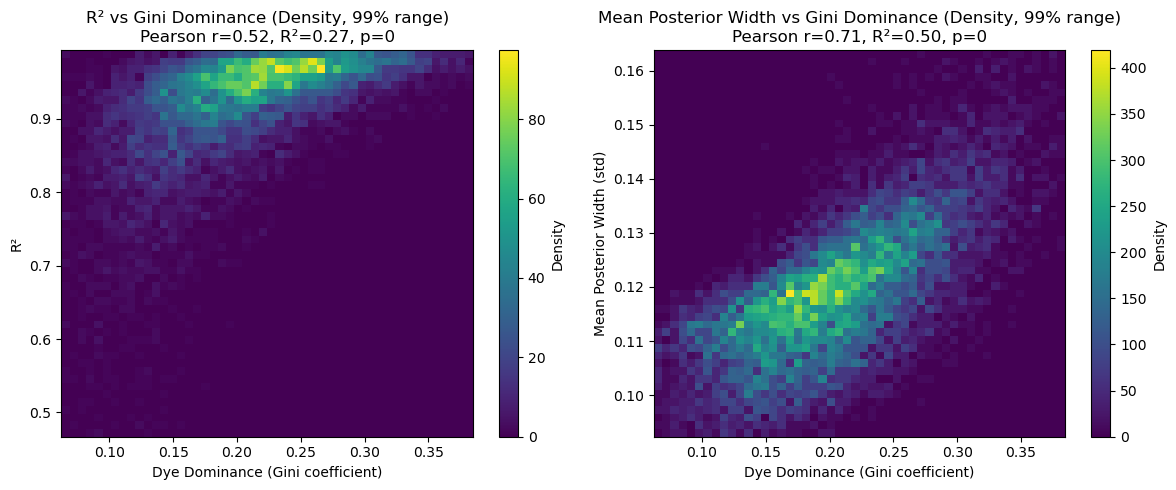

In [26]:
# Alternative dye dominance measure: Gini coefficient
def gini_coefficient(fractions):
    # fractions: shape (n_samples, n_dyes)
    sorted_fractions = np.sort(fractions, axis=1)
    n = fractions.shape[1]
    index = np.arange(1, n + 1)
    # Gini formula for each row
    gini = (np.sum((2 * index - n - 1) * sorted_fractions, axis=1)) / (n * np.sum(sorted_fractions, axis=1))
    return gini

gini_dominance = gini_coefficient(dye_fractions)

# Compute 0.5th and 99.5th percentiles for all axes
x_min, x_max = np.percentile(gini_dominance, [0.5, 99.5])
y1_min, y1_max = np.percentile(r2_scores, [0.5, 99.5])
y2_min, y2_max = np.percentile(mean_width, [0.5, 99.5])

# Compute correlations
corr_r2, pval_r2 = pearsonr(gini_dominance, r2_scores)
r2_r2 = corr_r2 ** 2
corr_width, pval_width = pearsonr(gini_dominance, mean_width)
r2_width = corr_width ** 2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gini dominance vs R² (density, 99% range)
h1 = axes[0].hist2d(gini_dominance, r2_scores, bins=[50, 50], range=[[x_min, x_max], [y1_min, y1_max]], cmap='viridis', density=True)
plt.colorbar(h1[3], ax=axes[0], label='Density')
axes[0].set_xlabel('Dye Dominance (Gini coefficient)')
axes[0].set_ylabel('R²')
axes[0].set_title(f'R² vs Gini Dominance (Density, 99% range)\nPearson r={corr_r2:.2f}, R²={r2_r2:.2f}, p={pval_r2:.2g}')
axes[0].set_ylim(y1_min, y1_max)

# Gini dominance vs mean posterior width (density, 99% range)
h2 = axes[1].hist2d(gini_dominance, mean_width, bins=[50, 50], range=[[x_min, x_max], [y2_min, y2_max]], cmap='viridis', density=True)
plt.colorbar(h2[3], ax=axes[1], label='Density')
axes[1].set_xlabel('Dye Dominance (Gini coefficient)')
axes[1].set_ylabel('Mean Posterior Width (std)')
axes[1].set_title(f'Mean Posterior Width vs Gini Dominance (Density, 99% range)\nPearson r={corr_width:.2f}, R²={r2_width:.2f}, p={pval_width:.2g}')
axes[1].set_ylim(y2_min, y2_max)

plt.tight_layout()
plt.show()

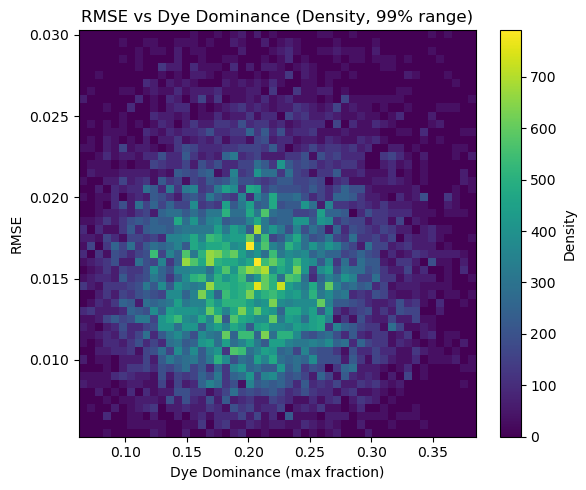

In [27]:
# Dye dominance vs RMSE (density) with bins covering 99% of the data
import numpy as np
# Compute 0.5th and 99.5th percentiles for both axes
x_min, x_max = np.percentile(gini_dominance, [0.5, 99.5])
y_min, y_max = np.percentile(rmse_scores, [0.5, 99.5])

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
h3 = ax.hist2d(gini_dominance, rmse_scores, bins=[50, 50], range=[[x_min, x_max], [y_min, y_max]], cmap='viridis', density=True)
plt.colorbar(h3[3], ax=ax, label='Density')
ax.set_xlabel('Dye Dominance (max fraction)')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Dye Dominance (Density, 99% range)')
plt.tight_layout()
plt.show()

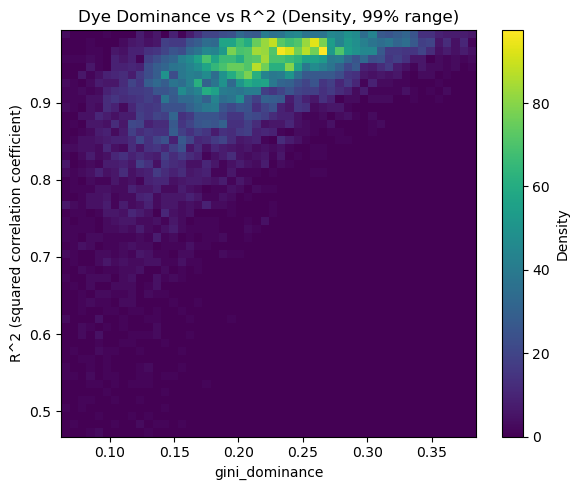

In [35]:
# Dye dominance vs RMSE (density) with bins covering 99% of the data
import numpy as np
# Compute 0.5th and 99.5th percentiles for both axes
x_min, x_max = np.percentile(gini_dominance, [0.5, 99.5])
y_min, y_max = np.percentile(r2_scores, [0.5, 99.5])

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
h3 = ax.hist2d(gini_dominance,r2_scores, bins=[50, 50], range=[[x_min, x_max], [y_min, y_max]], cmap='viridis', density=True)
plt.colorbar(h3[3], ax=ax, label='Density')
ax.set_xlabel('gini_dominance')
ax.set_ylabel('R^2 (squared correlation coefficient)')
ax.set_title('Dye Dominance vs R^2 (Density, 99% range)')
plt.tight_layout()
plt.show()

In [34]:
# Calculate Pearson R^2 (squared correlation) between dye dominance and RMSE
from scipy.stats import pearsonr
corr, pval = pearsonr(gini_dominance,r2_scores)
r2 = corr**2
print(f"Pearson r: {corr:.3f}, R^2: {r2:.3f}, p-value: {pval:.2g}")

Pearson r: 0.519, R^2: 0.270, p-value: 0


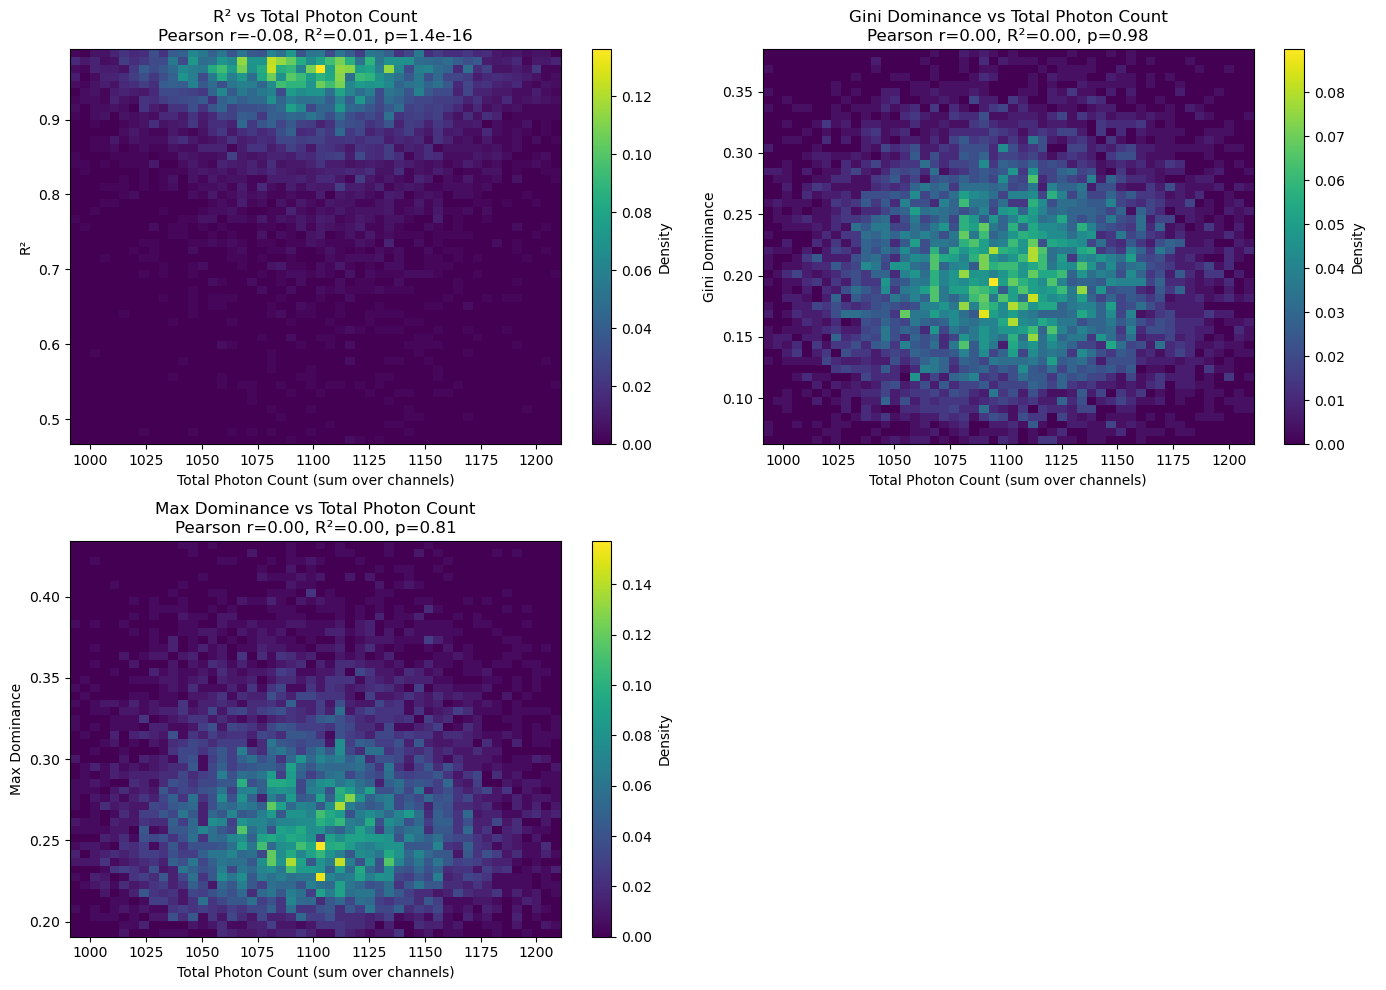

In [39]:
# Plot: Distribution of total photon counts from the simulator as a function of R², Gini dominance, and max dominance
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Get photon counts from simulator results (assume 'val_x' is the simulated measurement, shape: (n_val, n_channels))
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
if val_x is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    total_photons = np.sum(val_x_np, axis=1)
    r2_scores = np.array(trainer.results['r2_scores'])
    # Gini and max dominance (assume dye_fractions, gini_dominance, dominance already computed)
    # Compute 0.5th and 99.5th percentiles for all axes
    x_min, x_max = np.percentile(total_photons, [0.5, 99.5])
    y1_min, y1_max = np.percentile(r2_scores, [0.5, 99.5])
    y2_min, y2_max = np.percentile(gini_dominance, [0.5, 99.5])
    y3_min, y3_max = np.percentile(dominance, [0.5, 99.5])
    # Compute correlations
    corr_r2, pval_r2 = pearsonr(total_photons, r2_scores)
    r2_r2 = corr_r2 ** 2
    corr_gini, pval_gini = pearsonr(total_photons, gini_dominance)
    r2_gini = corr_gini ** 2
    corr_max, pval_max = pearsonr(total_photons, dominance)
    r2_max = corr_max ** 2
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    # Photon count vs R²
    h1 = axes[0,0].hist2d(total_photons, r2_scores, bins=[50, 50], range=[[x_min, x_max], [y1_min, y1_max]], cmap='viridis', density=True)
    plt.colorbar(h1[3], ax=axes[0,0], label='Density')
    axes[0,0].set_xlabel('Total Photon Count (sum over channels)')
    axes[0,0].set_ylabel('R²')
    axes[0,0].set_title(f'R² vs Total Photon Count\nPearson r={corr_r2:.2f}, R²={r2_r2:.2f}, p={pval_r2:.2g}')
    axes[0,0].set_ylim(y1_min, y1_max)
    # Photon count vs Gini dominance
    h2 = axes[0,1].hist2d(total_photons, gini_dominance, bins=[50, 50], range=[[x_min, x_max], [y2_min, y2_max]], cmap='viridis', density=True)
    plt.colorbar(h2[3], ax=axes[0,1], label='Density')
    axes[0,1].set_xlabel('Total Photon Count (sum over channels)')
    axes[0,1].set_ylabel('Gini Dominance')
    axes[0,1].set_title(f'Gini Dominance vs Total Photon Count\nPearson r={corr_gini:.2f}, R²={r2_gini:.2f}, p={pval_gini:.2g}')
    axes[0,1].set_ylim(y2_min, y2_max)
    # Photon count vs max dominance
    h3 = axes[1,0].hist2d(total_photons, dominance, bins=[50, 50], range=[[x_min, x_max], [y3_min, y3_max]], cmap='viridis', density=True)
    plt.colorbar(h3[3], ax=axes[1,0], label='Density')
    axes[1,0].set_xlabel('Total Photon Count (sum over channels)')
    axes[1,0].set_ylabel('Max Dominance')
    axes[1,0].set_title(f'Max Dominance vs Total Photon Count\nPearson r={corr_max:.2f}, R²={r2_max:.2f}, p={pval_max:.2g}')
    axes[1,0].set_ylim(y3_min, y3_max)
    # Hide unused subplot
    axes[1,1].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('Photon count data (val_x) not found in trainer results.')

In [25]:
# Section 9: Save ExperimenZt Results
trainer.save()


Experiment results saved to sbi_training_demo_results/results.pt


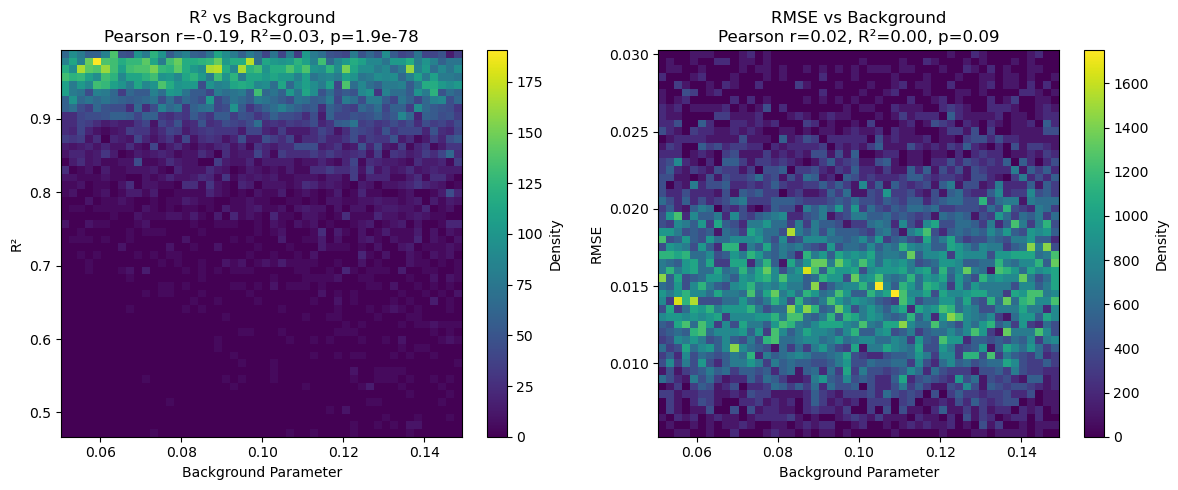

In [40]:
# Plot: R² and RMSE as a function of background parameter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Get background parameter (assume last column of val_theta if background is present)
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']
names = list(trainer.simulator.config.dye_names)
has_bg = hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye
if has_bg and val_theta.shape[1] > len(names):
    bg = val_theta[:, -1]
    r2_scores = np.array(trainer.results['r2_scores'])
    rmse_scores = np.array(trainer.results['rmse_scores'])
    # Compute 0.5th and 99.5th percentiles for all axes
    x_min, x_max = np.percentile(bg, [0.5, 99.5])
    y1_min, y1_max = np.percentile(r2_scores, [0.5, 99.5])
    y2_min, y2_max = np.percentile(rmse_scores, [0.5, 99.5])
    # Compute correlations
    corr_r2, pval_r2 = pearsonr(bg, r2_scores)
    r2_r2 = corr_r2 ** 2
    corr_rmse, pval_rmse = pearsonr(bg, rmse_scores)
    r2_rmse = corr_rmse ** 2
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Background vs R²
    h1 = axes[0].hist2d(bg, r2_scores, bins=[50, 50], range=[[x_min, x_max], [y1_min, y1_max]], cmap='viridis', density=True)
    plt.colorbar(h1[3], ax=axes[0], label='Density')
    axes[0].set_xlabel('Background Parameter')
    axes[0].set_ylabel('R²')
    axes[0].set_title(f'R² vs Background\nPearson r={corr_r2:.2f}, R²={r2_r2:.2f}, p={pval_r2:.2g}')
    axes[0].set_ylim(y1_min, y1_max)
    # Background vs RMSE
    h2 = axes[1].hist2d(bg, rmse_scores, bins=[50, 50], range=[[x_min, x_max], [y2_min, y2_max]], cmap='viridis', density=True)
    plt.colorbar(h2[3], ax=axes[1], label='Density')
    axes[1].set_xlabel('Background Parameter')
    axes[1].set_ylabel('RMSE')
    axes[1].set_title(f'RMSE vs Background\nPearson r={corr_rmse:.2f}, R²={r2_rmse:.2f}, p={pval_rmse:.2g}')
    axes[1].set_ylim(y2_min, y2_max)
    plt.tight_layout()
    plt.show()
else:
    print('No background parameter found in val_theta.')

## Advanced Posterior Analysis for Demultiplexing
This section explores advanced ways to analyze the posterior to find the best parameters for demultiplexing, including:
- Posterior width (uncertainty) vs. parameter space
- Mutual information between observations and parameters
- Posterior predictive checks
- Entropy maps
- Coverage probability
- Mode separation and multimodality
- Fisher information analysis
- Parameter correlation in the posterior
- Posterior volume (determinant of covariance)
- Active learning/experimental design

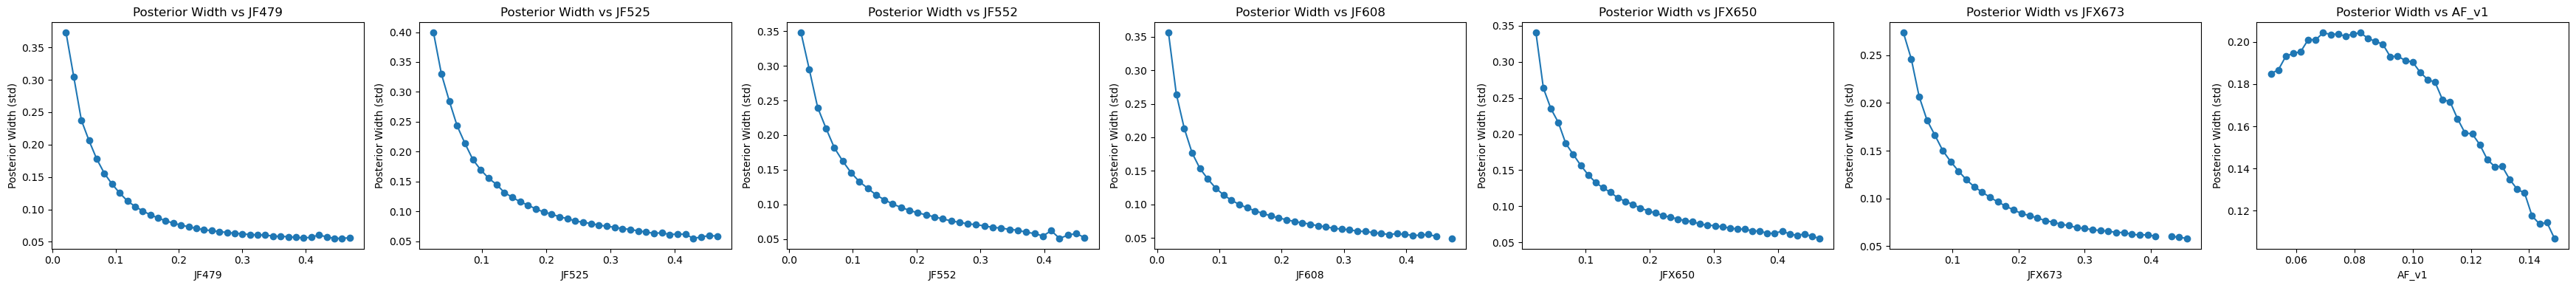

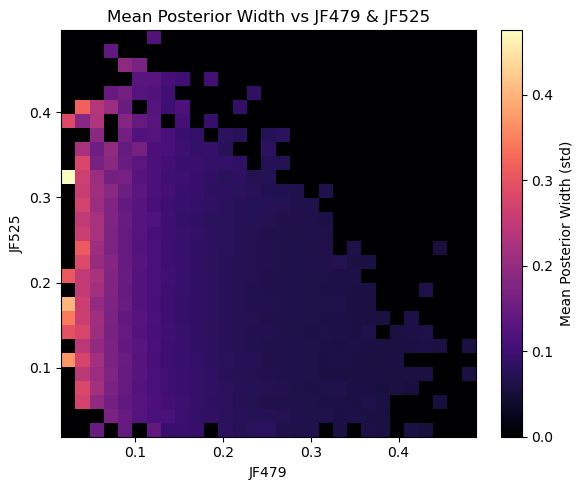

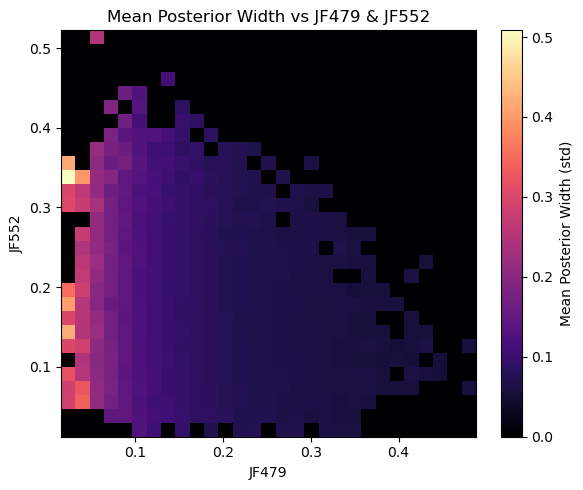

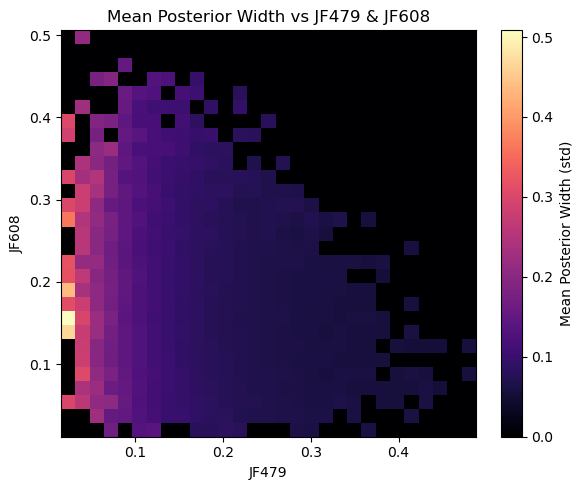

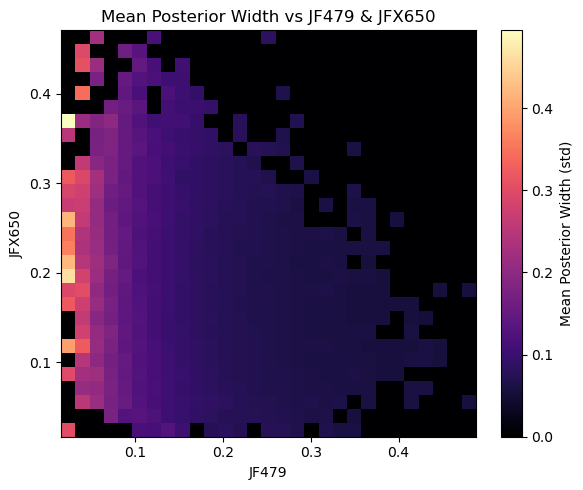

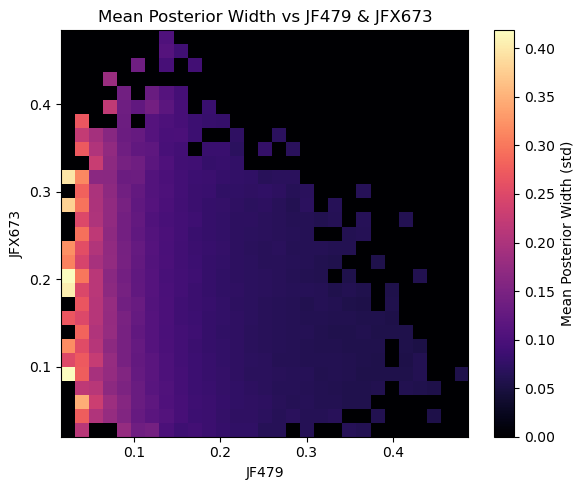

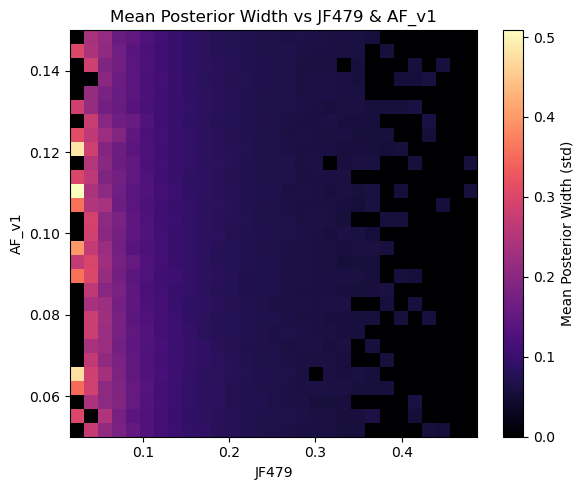

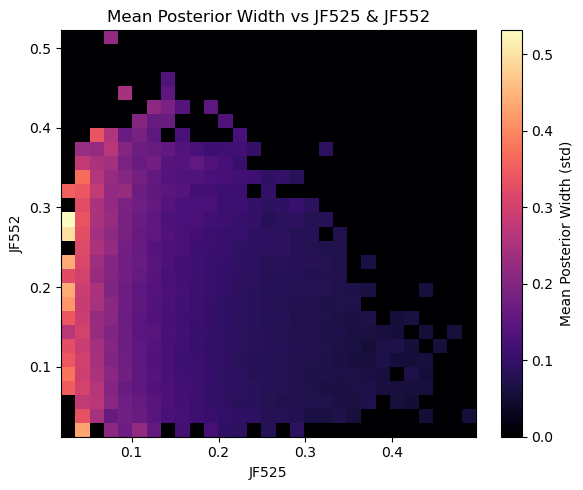

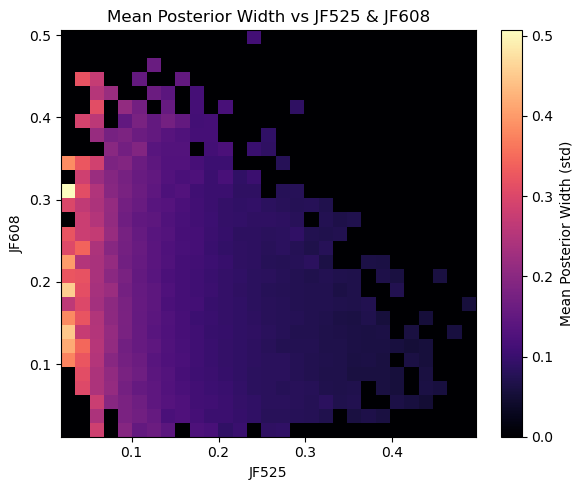

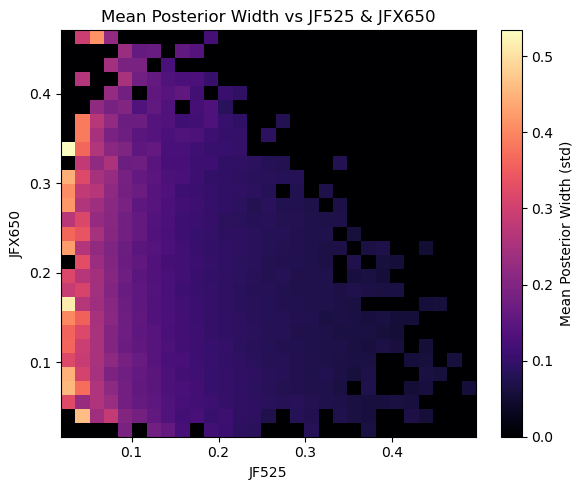

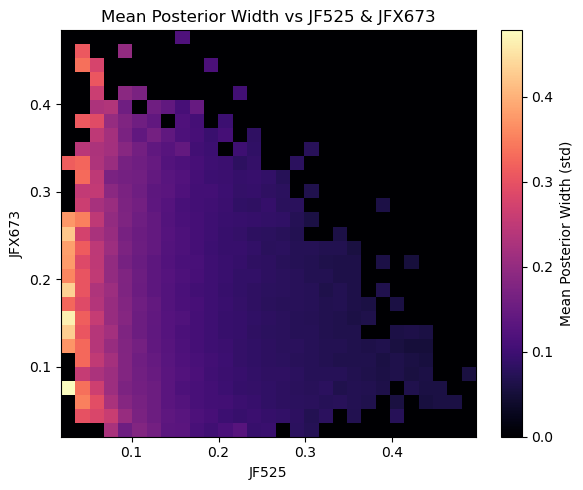

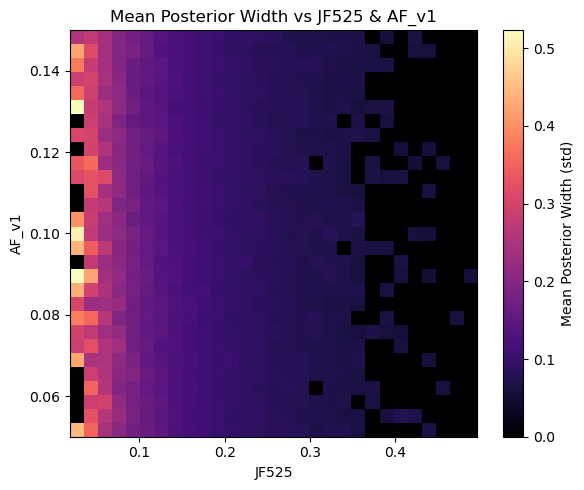

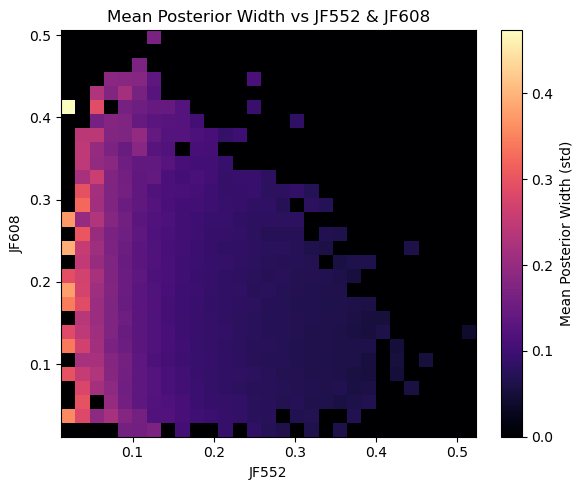

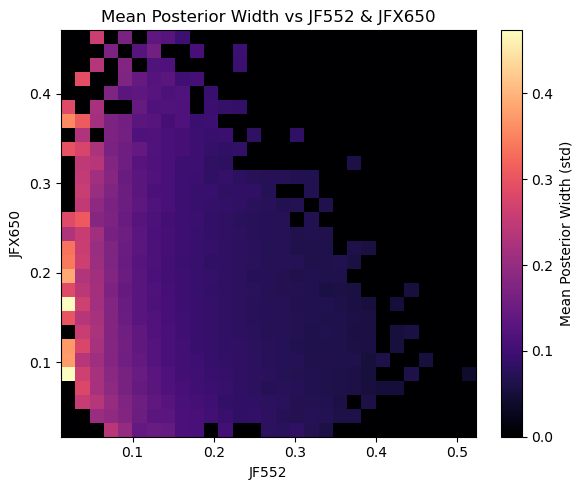

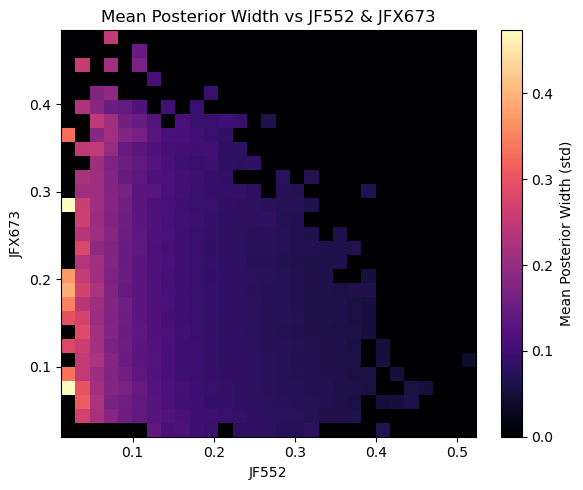

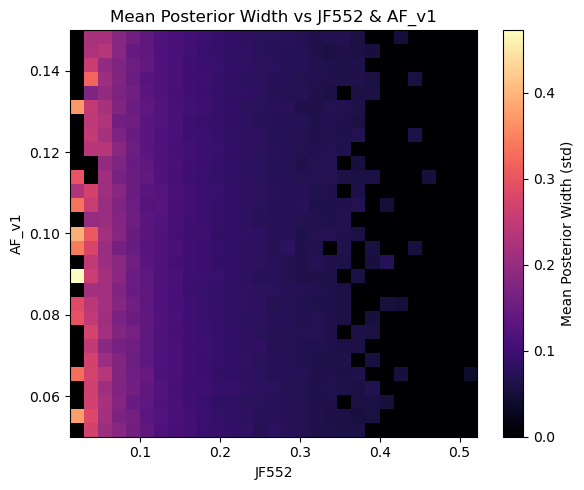

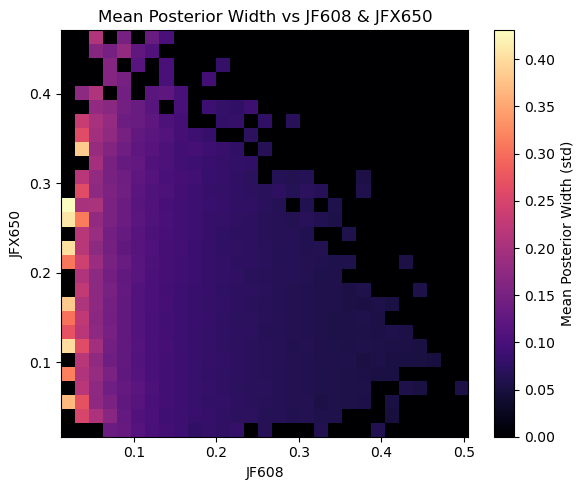

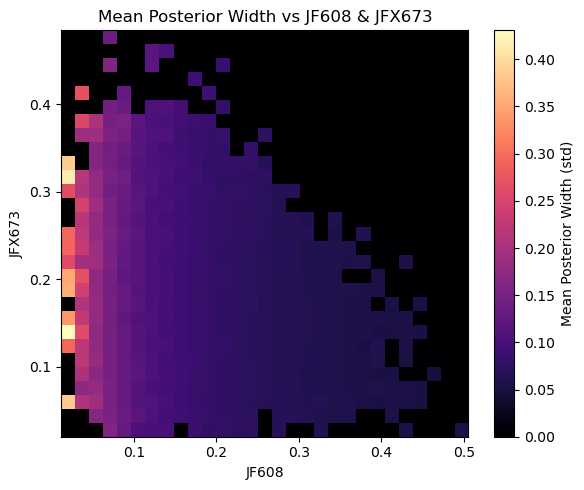

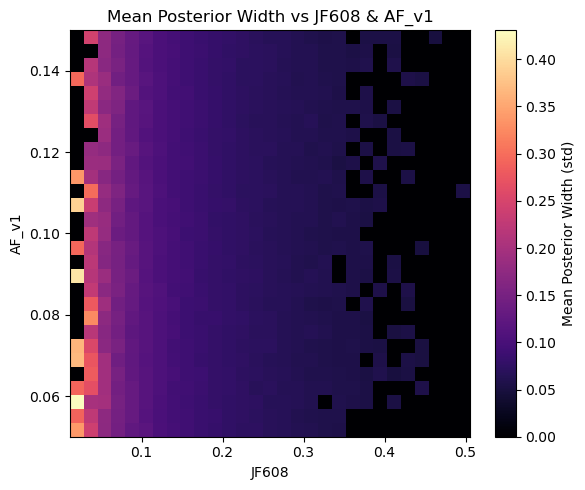

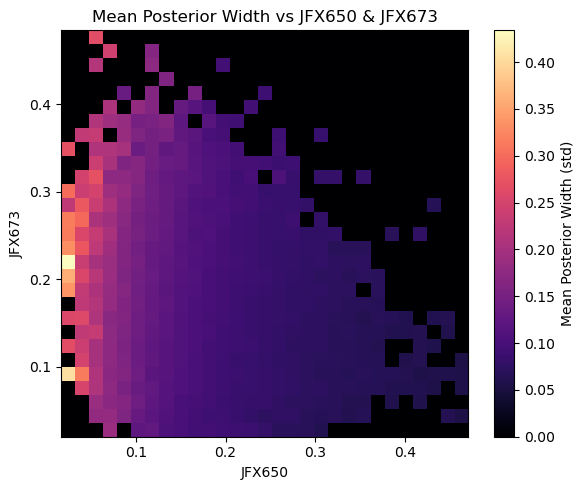

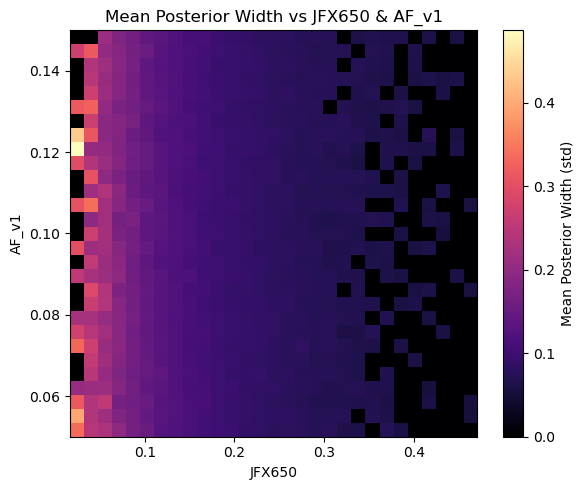

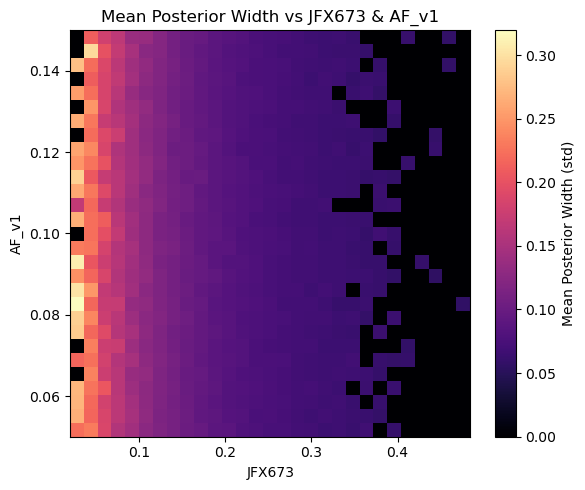

In [41]:
# 1. Posterior width (uncertainty) vs. parameter space
import numpy as np
import matplotlib.pyplot as plt

posterior_width = trainer.results['posterior_width']  # shape: (n_val, n_params)
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']
names = list(trainer.simulator.config.dye_names)
if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
    names = names + [trainer.simulator.config.bg_dye]
n_params = posterior_width.shape[1]

# Plot posterior width vs each parameter
fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 4))
if n_params == 1:
    axes = [axes]
for i in range(n_params):
    x = val_theta[:, i]
    y = posterior_width[:, i]
    # Bin x for smoother curves
    bins = np.linspace(x.min(), x.max(), 40)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    inds = np.digitize(x, bins) - 1
    mean_width = [np.mean(y[inds == j]) if np.any(inds == j) else np.nan for j in range(len(bin_centers))]
    axes[i].plot(bin_centers, mean_width, marker='o')
    axes[i].set_xlabel(f'{names[i]}')
    axes[i].set_ylabel('Posterior Width (std)')
    axes[i].set_title(f'Posterior Width vs {names[i]}')
plt.tight_layout()
plt.show()

# Pairwise heatmaps: mean posterior width as a function of parameter pairs
if n_params > 1:
    from itertools import combinations
    combs = list(combinations(range(n_params), 2))
    for i, j in combs:
        xi, xj = val_theta[:, i], val_theta[:, j]
        width_ij = posterior_width[:, i]
        bins_i = np.linspace(xi.min(), xi.max(), 30)
        bins_j = np.linspace(xj.min(), xj.max(), 30)
        H, xedges, yedges = np.histogram2d(xi, xj, bins=[bins_i, bins_j], weights=width_ij)
        counts, _, _ = np.histogram2d(xi, xj, bins=[bins_i, bins_j])
        mean_width_2d = np.divide(H, counts, out=np.zeros_like(H), where=counts>0)
        plt.figure(figsize=(6,5))
        plt.imshow(mean_width_2d.T, origin='lower', aspect='auto', extent=[bins_i[0], bins_i[-1], bins_j[0], bins_j[-1]], cmap='magma')
        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.title(f'Mean Posterior Width vs {names[i]} & {names[j]}')
        plt.colorbar(label='Mean Posterior Width (std)')
        plt.tight_layout()
        plt.show()

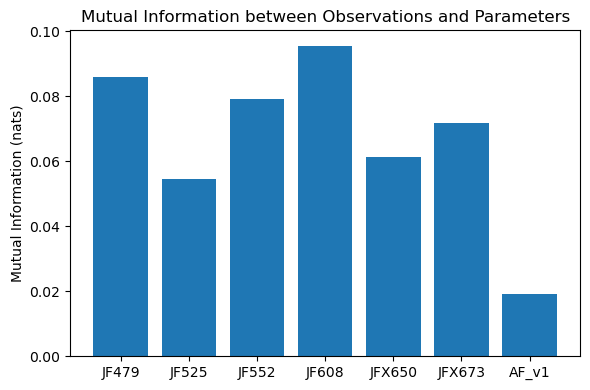

In [42]:
# 2. Mutual information between observations and parameters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

# Use validation data: val_x (observations), val_theta (parameters)
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']

if val_x is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    n_params = val_theta.shape[1]
    mi = []
    for i in range(n_params):
        # Mutual information between each parameter and the full observation vector
        mi_i = mutual_info_regression(val_x_np, val_theta[:, i], random_state=0)
        mi.append(np.mean(mi_i))  # Average MI across all channels
    names = list(trainer.simulator.config.dye_names)
    if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
        names = names + [trainer.simulator.config.bg_dye]
    if len(names) < n_params:
        names += [f'Param {i+1}' for i in range(len(names), n_params)]
    plt.figure(figsize=(6, 4))
    plt.bar(names, mi)
    plt.ylabel('Mutual Information (nats)')
    plt.title('Mutual Information between Observations and Parameters')
    plt.tight_layout()
    plt.show()
else:
    print('Observation data (val_x) not found in trainer results.')

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples: 1054it [00:00, 2094.00it/s]                         
/tmp/ipykernel_204802/2816025158.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(samples, labels=names, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]
/tmp/ipykernel_204802/2816025158.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(samples, labels=names, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
Drawing 1000 posterior samples: 1029it [00:00, 1521.25it/s]                         
/tmp/ipykernel_204802/2816025158.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been rena

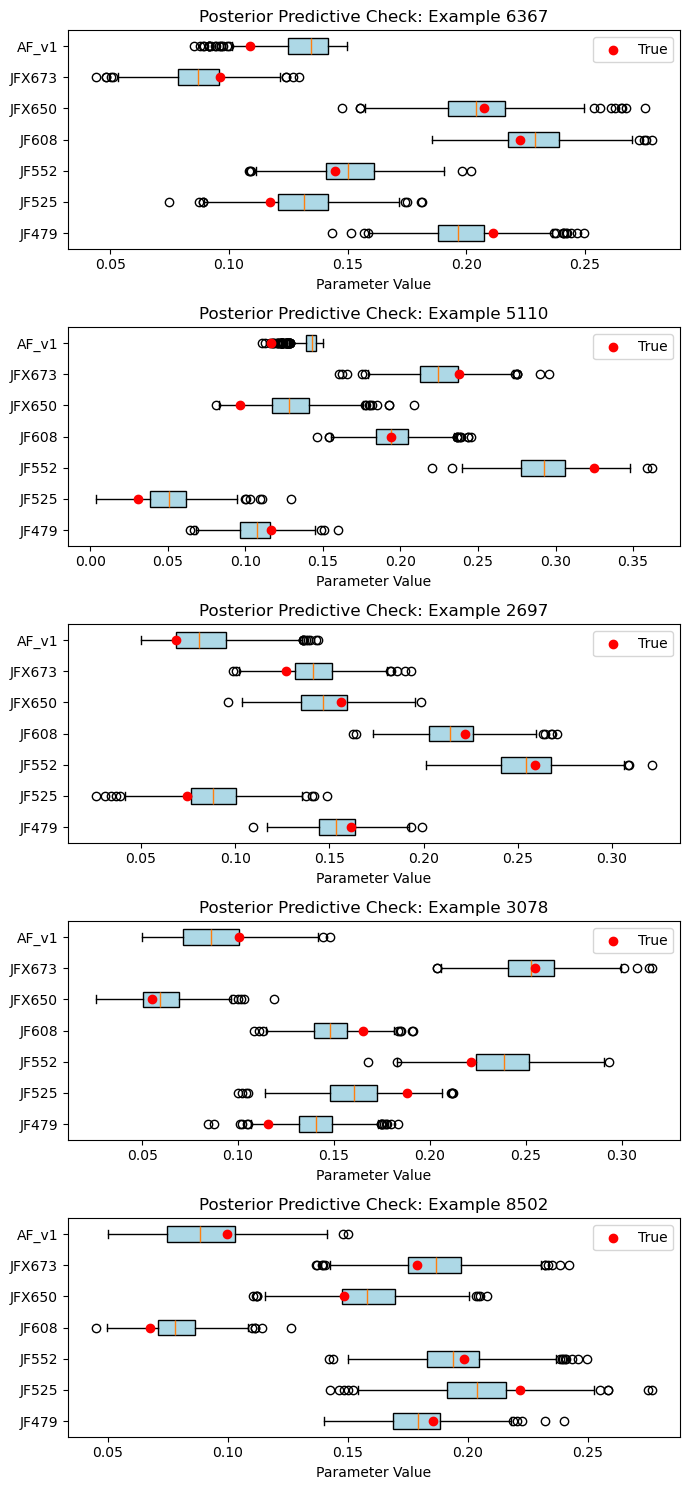

In [44]:
# 3. Posterior Predictive Checks
import numpy as np
import matplotlib.pyplot as plt

# Draw samples from the posterior for a random subset of validation observations
n_examples = 5  # Number of examples to visualize
n_samples = 1000  # Number of posterior samples per example
rng = np.random.default_rng(0)

val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']

if val_x is not None and hasattr(trainer, 'posterior') and trainer.posterior is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    idxs = rng.choice(len(val_x_np), size=n_examples, replace=False)
    fig, axes = plt.subplots(n_examples, 1, figsize=(7, 3 * n_examples))
    if n_examples == 1:
        axes = [axes]
    for i, idx in enumerate(idxs):
        obs = val_x_np[idx:idx+1]
        # Draw posterior samples for this observation
        samples = trainer.posterior.sample((n_samples,), x=torch.tensor(obs, dtype=torch.float32))
        samples = samples.detach().cpu().numpy()
        # Plot true parameter vs posterior samples for each parameter
        n_params = samples.shape[1]
        names = list(trainer.simulator.config.dye_names)
        if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
            names = names + [trainer.simulator.config.bg_dye]
        if len(names) < n_params:
            names += [f'Param {j+1}' for j in range(len(names), n_params)]
        axes[i].boxplot(samples, labels=names, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        axes[i].scatter(val_theta[idx], np.arange(1, n_params+1), color='red', label='True', zorder=3)
        axes[i].set_title(f'Posterior Predictive Check: Example {idx}')
        axes[i].set_xlabel('Parameter Value')
        axes[i].legend()
    plt.tight_layout()
    plt.show()
else:
    print('Posterior or validation data not found for predictive checks.')

  0%|          | 0/100 [00:00<?, ?it/s]

Computing entropy for validation example 1/10000


  1%|          | 1/100 [00:00<00:48,  2.05it/s]

Computing entropy for validation example 2/10000


  2%|▏         | 2/100 [00:00<00:48,  2.02it/s]

Computing entropy for validation example 3/10000


  3%|▎         | 3/100 [00:01<00:58,  1.65it/s]

Computing entropy for validation example 4/10000


  4%|▍         | 4/100 [00:02<00:53,  1.78it/s]

Computing entropy for validation example 5/10000


  5%|▌         | 5/100 [00:02<00:51,  1.86it/s]

Computing entropy for validation example 6/10000


  6%|▌         | 6/100 [00:03<00:51,  1.83it/s]

Computing entropy for validation example 7/10000


  7%|▋         | 7/100 [00:03<00:48,  1.90it/s]

Computing entropy for validation example 8/10000


  8%|▊         | 8/100 [00:04<00:47,  1.94it/s]

Computing entropy for validation example 9/10000


  9%|▉         | 9/100 [00:04<00:47,  1.91it/s]

Computing entropy for validation example 10/10000


 10%|█         | 10/100 [00:05<00:53,  1.68it/s]

Computing entropy for validation example 11/10000


 11%|█         | 11/100 [00:06<00:51,  1.72it/s]

Computing entropy for validation example 12/10000


 12%|█▏        | 12/100 [00:06<00:48,  1.81it/s]

Computing entropy for validation example 13/10000


 13%|█▎        | 13/100 [00:07<00:49,  1.76it/s]

Computing entropy for validation example 14/10000


 14%|█▍        | 14/100 [00:07<00:48,  1.78it/s]

Computing entropy for validation example 15/10000


 15%|█▌        | 15/100 [00:08<00:46,  1.81it/s]

Computing entropy for validation example 16/10000


 16%|█▌        | 16/100 [00:08<00:45,  1.84it/s]

Computing entropy for validation example 17/10000


 17%|█▋        | 17/100 [00:09<00:44,  1.85it/s]

Computing entropy for validation example 18/10000


 18%|█▊        | 18/100 [00:09<00:43,  1.87it/s]

Computing entropy for validation example 19/10000


 19%|█▉        | 19/100 [00:10<00:42,  1.90it/s]

Computing entropy for validation example 20/10000


 20%|██        | 20/100 [00:10<00:41,  1.93it/s]

Computing entropy for validation example 21/10000


 21%|██        | 21/100 [00:11<00:44,  1.77it/s]

Computing entropy for validation example 22/10000


 22%|██▏       | 22/100 [00:12<00:43,  1.77it/s]

Computing entropy for validation example 23/10000


 23%|██▎       | 23/100 [00:12<00:43,  1.75it/s]

Computing entropy for validation example 24/10000


 24%|██▍       | 24/100 [00:13<00:42,  1.78it/s]

Computing entropy for validation example 25/10000


 25%|██▌       | 25/100 [00:13<00:41,  1.81it/s]

Computing entropy for validation example 26/10000


 26%|██▌       | 26/100 [00:14<00:39,  1.87it/s]

Computing entropy for validation example 27/10000


 27%|██▋       | 27/100 [00:14<00:39,  1.86it/s]

Computing entropy for validation example 28/10000


 28%|██▊       | 28/100 [00:15<00:37,  1.90it/s]

Computing entropy for validation example 29/10000


 29%|██▉       | 29/100 [00:15<00:37,  1.90it/s]

Computing entropy for validation example 30/10000


 30%|███       | 30/100 [00:16<00:40,  1.72it/s]

Computing entropy for validation example 31/10000


 31%|███       | 31/100 [00:17<00:40,  1.72it/s]

Computing entropy for validation example 32/10000


 32%|███▏      | 32/100 [00:17<00:39,  1.74it/s]

Computing entropy for validation example 33/10000


 33%|███▎      | 33/100 [00:18<00:38,  1.74it/s]

Computing entropy for validation example 34/10000


 34%|███▍      | 34/100 [00:18<00:36,  1.80it/s]

Computing entropy for validation example 35/10000


 35%|███▌      | 35/100 [00:19<00:35,  1.85it/s]

Computing entropy for validation example 36/10000


 36%|███▌      | 36/100 [00:19<00:38,  1.66it/s]

Computing entropy for validation example 37/10000


 37%|███▋      | 37/100 [00:20<00:36,  1.73it/s]

Computing entropy for validation example 38/10000


 38%|███▊      | 38/100 [00:21<00:35,  1.74it/s]

Computing entropy for validation example 39/10000


 39%|███▉      | 39/100 [00:21<00:35,  1.74it/s]

Computing entropy for validation example 40/10000


 40%|████      | 40/100 [00:22<00:34,  1.74it/s]

Computing entropy for validation example 41/10000


 41%|████      | 41/100 [00:22<00:33,  1.75it/s]

Computing entropy for validation example 42/10000


 42%|████▏     | 42/100 [00:23<00:33,  1.75it/s]

Computing entropy for validation example 43/10000


 43%|████▎     | 43/100 [00:23<00:32,  1.73it/s]

Computing entropy for validation example 44/10000


 44%|████▍     | 44/100 [00:24<00:32,  1.74it/s]

Computing entropy for validation example 45/10000


 45%|████▌     | 45/100 [00:25<00:31,  1.75it/s]

Computing entropy for validation example 46/10000


 46%|████▌     | 46/100 [00:25<00:31,  1.74it/s]

Computing entropy for validation example 47/10000


 47%|████▋     | 47/100 [00:26<00:30,  1.77it/s]

Computing entropy for validation example 48/10000


 48%|████▊     | 48/100 [00:26<00:29,  1.78it/s]

Computing entropy for validation example 49/10000


 49%|████▉     | 49/100 [00:27<00:29,  1.76it/s]

Computing entropy for validation example 50/10000


 50%|█████     | 50/100 [00:28<00:29,  1.67it/s]

Computing entropy for validation example 51/10000


 51%|█████     | 51/100 [00:28<00:28,  1.69it/s]

Computing entropy for validation example 52/10000


 52%|█████▏    | 52/100 [00:29<00:27,  1.72it/s]

Computing entropy for validation example 53/10000


 53%|█████▎    | 53/100 [00:29<00:28,  1.67it/s]

Computing entropy for validation example 54/10000


 54%|█████▍    | 54/100 [00:30<00:27,  1.67it/s]

Computing entropy for validation example 55/10000


 55%|█████▌    | 55/100 [00:31<00:29,  1.50it/s]

Computing entropy for validation example 56/10000


 56%|█████▌    | 56/100 [00:31<00:29,  1.50it/s]

Computing entropy for validation example 57/10000


 57%|█████▋    | 57/100 [00:32<00:28,  1.51it/s]

Computing entropy for validation example 58/10000


 58%|█████▊    | 58/100 [00:33<00:27,  1.52it/s]

Computing entropy for validation example 59/10000


 59%|█████▉    | 59/100 [00:33<00:27,  1.51it/s]

Computing entropy for validation example 60/10000


 60%|██████    | 60/100 [00:34<00:27,  1.47it/s]

Computing entropy for validation example 61/10000


 61%|██████    | 61/100 [00:35<00:25,  1.50it/s]

Computing entropy for validation example 62/10000


 62%|██████▏   | 62/100 [00:35<00:25,  1.50it/s]

Computing entropy for validation example 63/10000


 63%|██████▎   | 63/100 [00:36<00:24,  1.53it/s]

Computing entropy for validation example 64/10000


 64%|██████▍   | 64/100 [00:37<00:23,  1.54it/s]

Computing entropy for validation example 65/10000


 65%|██████▌   | 65/100 [00:38<00:25,  1.35it/s]

Computing entropy for validation example 66/10000


 66%|██████▌   | 66/100 [00:38<00:24,  1.39it/s]

Computing entropy for validation example 67/10000


 67%|██████▋   | 67/100 [00:39<00:25,  1.30it/s]

Computing entropy for validation example 68/10000


 68%|██████▊   | 68/100 [00:40<00:24,  1.33it/s]

Computing entropy for validation example 69/10000


 69%|██████▉   | 69/100 [00:41<00:22,  1.39it/s]

Computing entropy for validation example 70/10000


 70%|███████   | 70/100 [00:41<00:21,  1.42it/s]

Computing entropy for validation example 71/10000


 71%|███████   | 71/100 [00:42<00:20,  1.40it/s]

Computing entropy for validation example 72/10000


 72%|███████▏  | 72/100 [00:43<00:20,  1.39it/s]

Computing entropy for validation example 73/10000


 73%|███████▎  | 73/100 [00:43<00:19,  1.39it/s]

Computing entropy for validation example 74/10000


 74%|███████▍  | 74/100 [00:45<00:22,  1.16it/s]

Computing entropy for validation example 75/10000


 75%|███████▌  | 75/100 [00:45<00:20,  1.22it/s]

Computing entropy for validation example 76/10000


 76%|███████▌  | 76/100 [00:46<00:18,  1.27it/s]

Computing entropy for validation example 77/10000


 77%|███████▋  | 77/100 [00:47<00:17,  1.31it/s]

Computing entropy for validation example 78/10000


 78%|███████▊  | 78/100 [00:47<00:16,  1.30it/s]

Computing entropy for validation example 79/10000


 79%|███████▉  | 79/100 [00:48<00:17,  1.22it/s]

Computing entropy for validation example 80/10000


 80%|████████  | 80/100 [00:49<00:16,  1.23it/s]

Computing entropy for validation example 81/10000


 81%|████████  | 81/100 [00:50<00:15,  1.25it/s]

Computing entropy for validation example 82/10000


 82%|████████▏ | 82/100 [00:51<00:14,  1.28it/s]

Computing entropy for validation example 83/10000


 83%|████████▎ | 83/100 [00:51<00:13,  1.29it/s]

Computing entropy for validation example 84/10000


 84%|████████▍ | 84/100 [00:53<00:13,  1.16it/s]

Computing entropy for validation example 85/10000


 85%|████████▌ | 85/100 [00:53<00:12,  1.19it/s]

Computing entropy for validation example 86/10000


 86%|████████▌ | 86/100 [00:54<00:11,  1.20it/s]

Computing entropy for validation example 87/10000


 87%|████████▋ | 87/100 [00:55<00:10,  1.23it/s]

Computing entropy for validation example 88/10000


 88%|████████▊ | 88/100 [00:56<00:09,  1.25it/s]

Computing entropy for validation example 89/10000


 89%|████████▉ | 89/100 [00:57<00:09,  1.18it/s]

Computing entropy for validation example 90/10000


 90%|█████████ | 90/100 [00:58<00:08,  1.18it/s]

Computing entropy for validation example 91/10000


 91%|█████████ | 91/100 [00:58<00:07,  1.20it/s]

Computing entropy for validation example 92/10000


 92%|█████████▏| 92/100 [00:59<00:06,  1.22it/s]

Computing entropy for validation example 93/10000


 93%|█████████▎| 93/100 [01:00<00:05,  1.23it/s]

Computing entropy for validation example 94/10000


 94%|█████████▍| 94/100 [01:01<00:04,  1.22it/s]

Computing entropy for validation example 95/10000


 95%|█████████▌| 95/100 [01:02<00:04,  1.22it/s]

Computing entropy for validation example 96/10000


 96%|█████████▌| 96/100 [01:03<00:03,  1.13it/s]

Computing entropy for validation example 97/10000


 97%|█████████▋| 97/100 [01:04<00:02,  1.04it/s]

Computing entropy for validation example 98/10000


 98%|█████████▊| 98/100 [01:05<00:01,  1.06it/s]

Computing entropy for validation example 99/10000


 99%|█████████▉| 99/100 [01:05<00:00,  1.10it/s]

Computing entropy for validation example 100/10000


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]



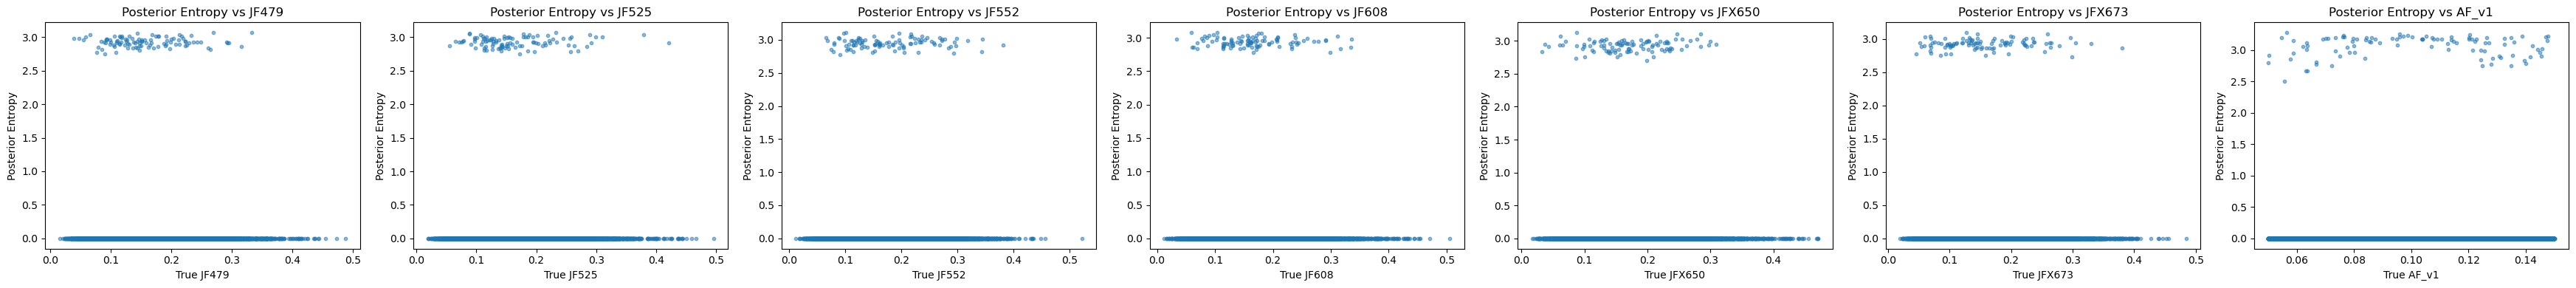

In [50]:
# 4. Entropy Maps: Visualize posterior entropy for each validation example
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from tqdm import tqdm

# Assume posterior samples are available for each validation example
n_samples = 1000
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']

if val_x is not None and hasattr(trainer, 'posterior') and trainer.posterior is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    n_val, n_params = val_theta.shape
    entropies = np.zeros((n_val, n_params))
    for i in tqdm(range(100)):
        print(f'Computing entropy for validation example {i+1}/{n_val}')
        obs = val_x_np[i:i+1]
        samples = trainer.posterior.sample((n_samples,), x=torch.tensor(obs, dtype=torch.float32), show_progress_bars=
                                           False)
        samples = samples.detach().cpu().numpy()
        # Compute entropy for each parameter (using histogram)
        for j in range(n_params):
           # print(f'  Parameter {j+1}/{n_params}')
            hist, bin_edges = np.histogram(samples[:, j], bins=30, density=True)
            entropies[i, j] = entropy(hist + 1e-8)  # add epsilon to avoid log(0)
    # Plot entropy for each parameter as a function of true parameter value
    names = list(trainer.simulator.config.dye_names)
    if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
        names = names + [trainer.simulator.config.bg_dye]
    if len(names) < n_params:
        names += [f'Param {k+1}' for k in range(len(names), n_params)]
    fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 4))
    if n_params == 1:
        axes = [axes]
    for j in range(n_params):
        axes[j].scatter(val_theta[:, j], entropies[:, j], alpha=0.5, s=10)
        axes[j].set_xlabel(f'True {names[j]}')
        axes[j].set_ylabel('Posterior Entropy')
        axes[j].set_title(f'Posterior Entropy vs {names[j]}')
    plt.tight_layout()
    plt.show()
else:
    print('Posterior or validation data not found for entropy analysis.')

Computing coverage for alpha=0.01
  Parameter 1/7, Example 1/10000
  Parameter 1/7, Example 11/10000
  Parameter 1/7, Example 11/10000
  Parameter 1/7, Example 21/10000
  Parameter 1/7, Example 21/10000
  Parameter 1/7, Example 31/10000
  Parameter 1/7, Example 31/10000
  Parameter 1/7, Example 41/10000
  Parameter 1/7, Example 41/10000
  Parameter 1/7, Example 51/10000
  Parameter 1/7, Example 51/10000
  Parameter 1/7, Example 61/10000
  Parameter 1/7, Example 61/10000
  Parameter 1/7, Example 71/10000
  Parameter 1/7, Example 71/10000
  Parameter 1/7, Example 81/10000
  Parameter 1/7, Example 81/10000
  Parameter 1/7, Example 91/10000
  Parameter 1/7, Example 91/10000
  Parameter 1/7, Example 101/10000
  Parameter 1/7, Example 101/10000
  Parameter 1/7, Example 111/10000
  Parameter 1/7, Example 111/10000
  Parameter 1/7, Example 121/10000
  Parameter 1/7, Example 121/10000
  Parameter 1/7, Example 131/10000
  Parameter 1/7, Example 131/10000
  Parameter 1/7, Example 141/10000
  Para

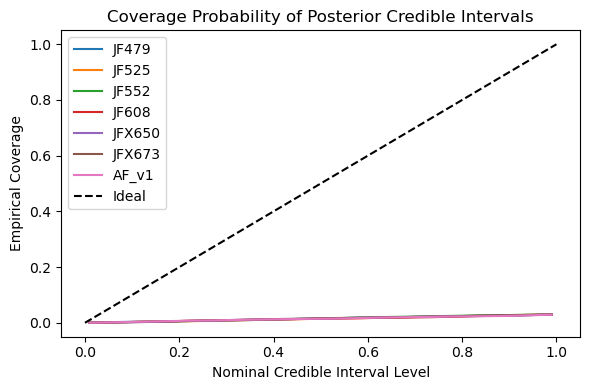

In [53]:
# 5. Coverage Probability: Empirical coverage of posterior credible intervals
import numpy as np
import matplotlib.pyplot as plt

n_samples = 1000
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']

if val_x is not None and hasattr(trainer, 'posterior') and trainer.posterior is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    n_val, n_params = val_theta.shape
    coverages = []
    alphas = np.linspace(0.01, 0.99, 20)  # Credible interval levels
    for alpha in alphas:
        print(f'Computing coverage for alpha={alpha:.2f}')
        covered = np.zeros(n_params)
        for j in range(n_params):
            count = 0
            for i in range(300):
                if i % 100 == 0:
                    print(f'  Parameter {j+1}/{n_params}, Example {i+1}/{n_val}')
                obs = val_x_np[i:i+1]
                samples = trainer.posterior.sample((n_samples,), x=torch.tensor(obs, dtype=torch.float32), show_progress_bars=False)
                samples = samples.detach().cpu().numpy()[:, j]
                lower = np.percentile(samples, 100 * (1 - alpha) / 2)
                upper = np.percentile(samples, 100 * (1 + alpha) / 2)
                if lower <= val_theta[i, j] <= upper:
                    count += 1
            covered[j] = count / n_val
        coverages.append(covered)
    coverages = np.array(coverages)
    names = list(trainer.simulator.config.dye_names)
    if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
        names = names + [trainer.simulator.config.bg_dye]
    if len(names) < n_params:
        names += [f'Param {k+1}' for k in range(len(names), n_params)]
    plt.figure(figsize=(6, 4))
    for j in range(n_params):
        plt.plot(alphas, coverages[:, j], label=names[j])
    plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
    plt.xlabel('Nominal Credible Interval Level')
    plt.ylabel('Empirical Coverage')
    plt.title('Coverage Probability of Posterior Credible Intervals')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Posterior or validation data not found for coverage analysis.')

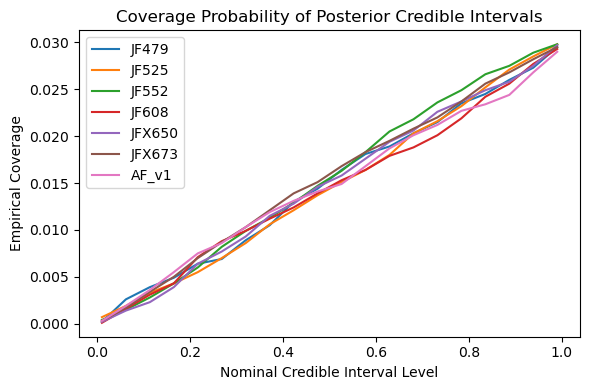

In [54]:
plt.figure(figsize=(6, 4))
for j in range(n_params):
    plt.plot(alphas, coverages[:, j], label=names[j])
plt.xlabel('Nominal Credible Interval Level')
plt.ylabel('Empirical Coverage')
plt.title('Coverage Probability of Posterior Credible Intervals')
plt.legend()
plt.tight_layout()
plt.show()

Drawing 10000 posterior samples: 10146it [00:00, 12041.58it/s]                          



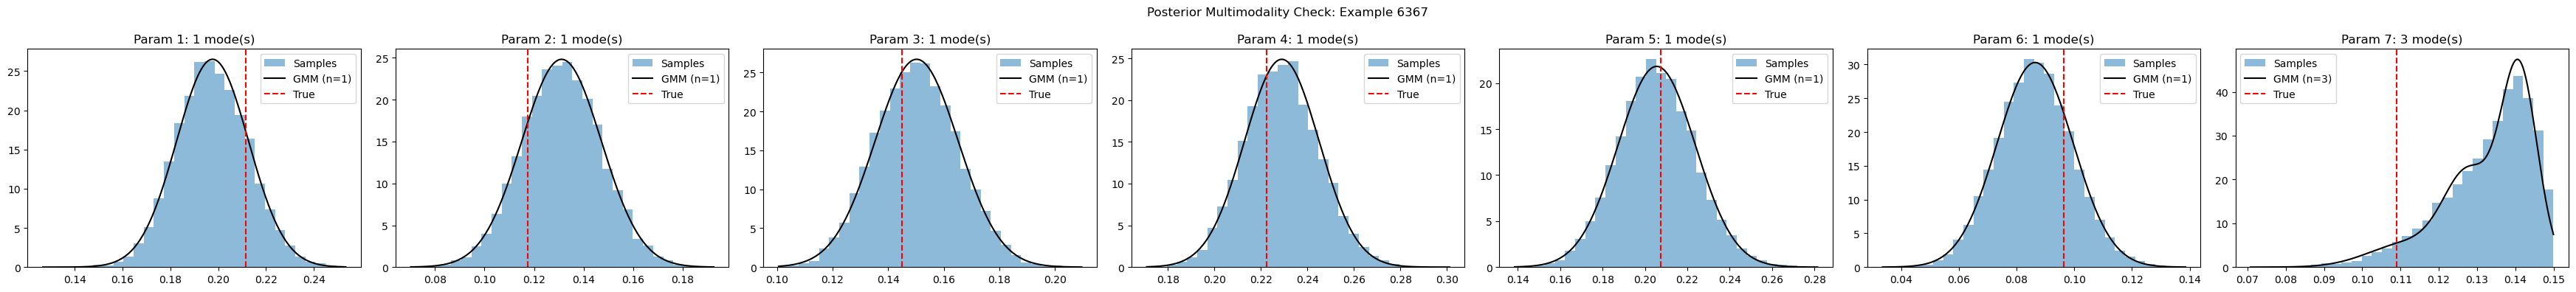

Drawing 10000 posterior samples: 10353it [00:03, 3424.62it/s]                          



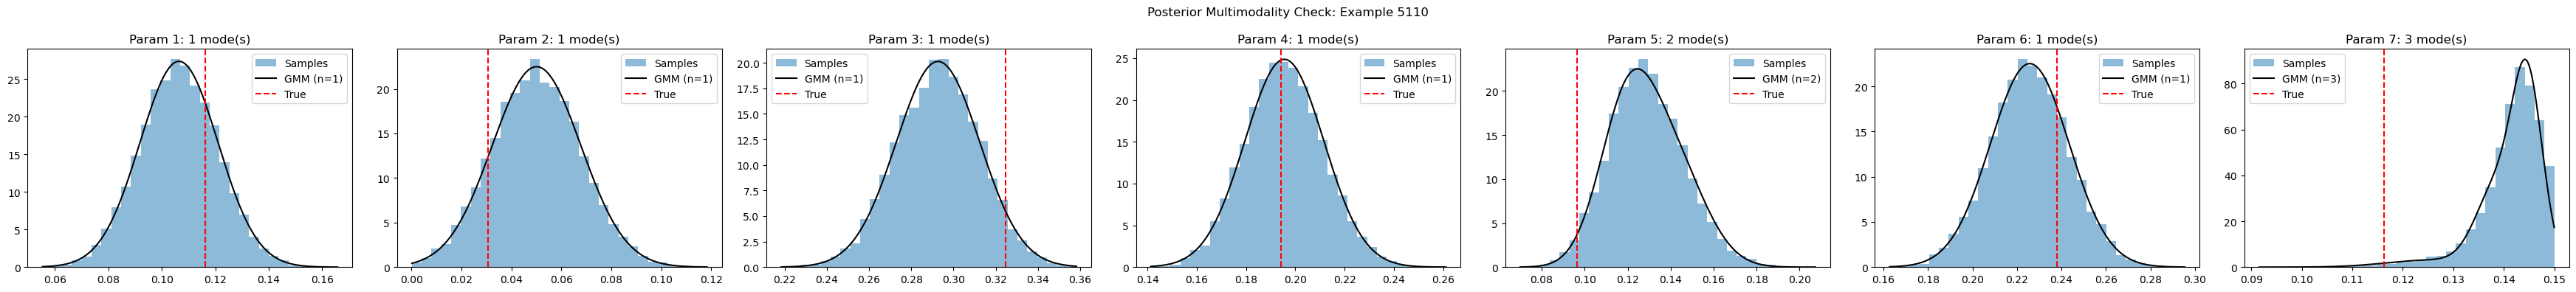

Drawing 10000 posterior samples: 10073it [00:00, 12048.25it/s]                          



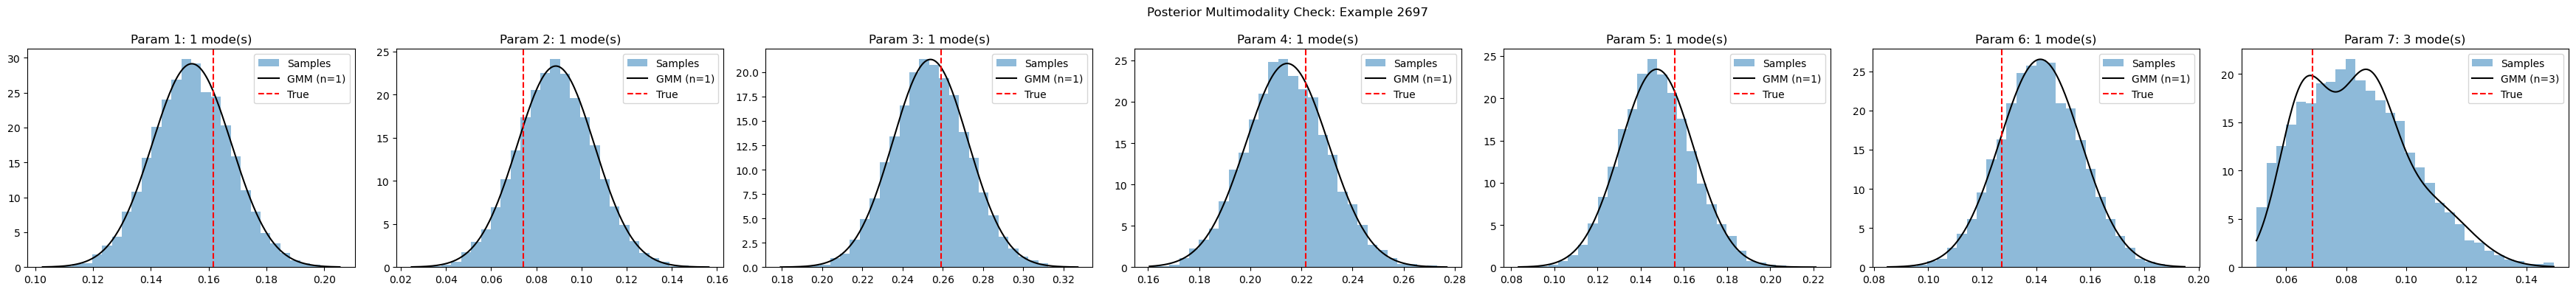

Drawing 10000 posterior samples: 10035it [00:00, 12595.38it/s]                          



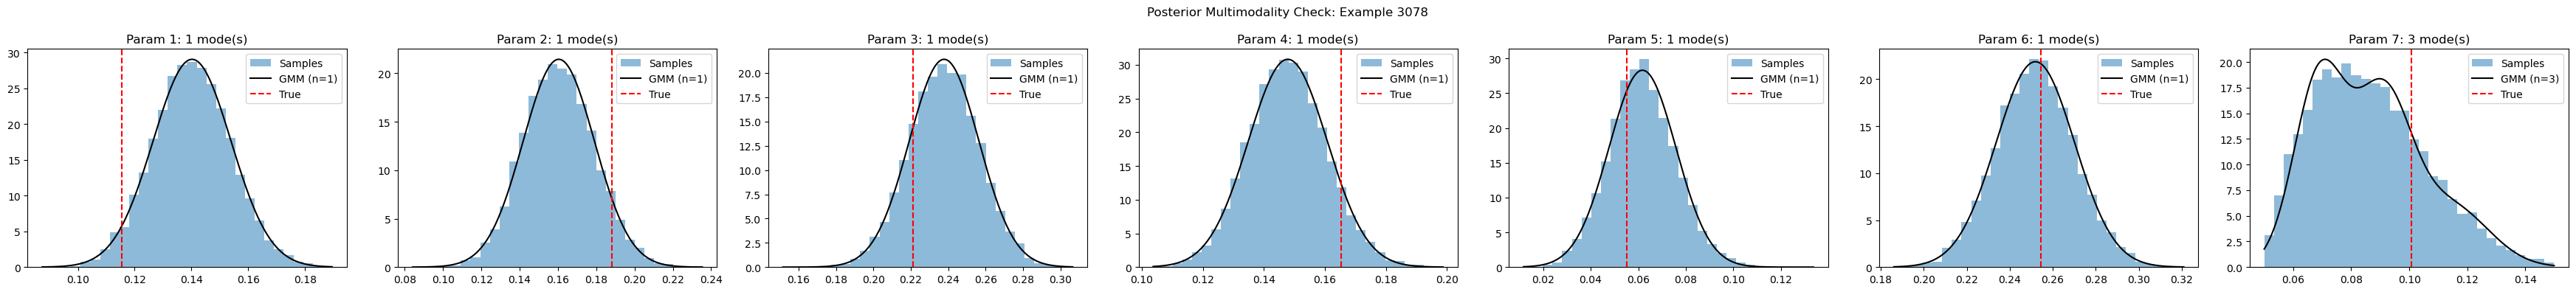

Drawing 10000 posterior samples: 10041it [00:00, 14944.23it/s]                          



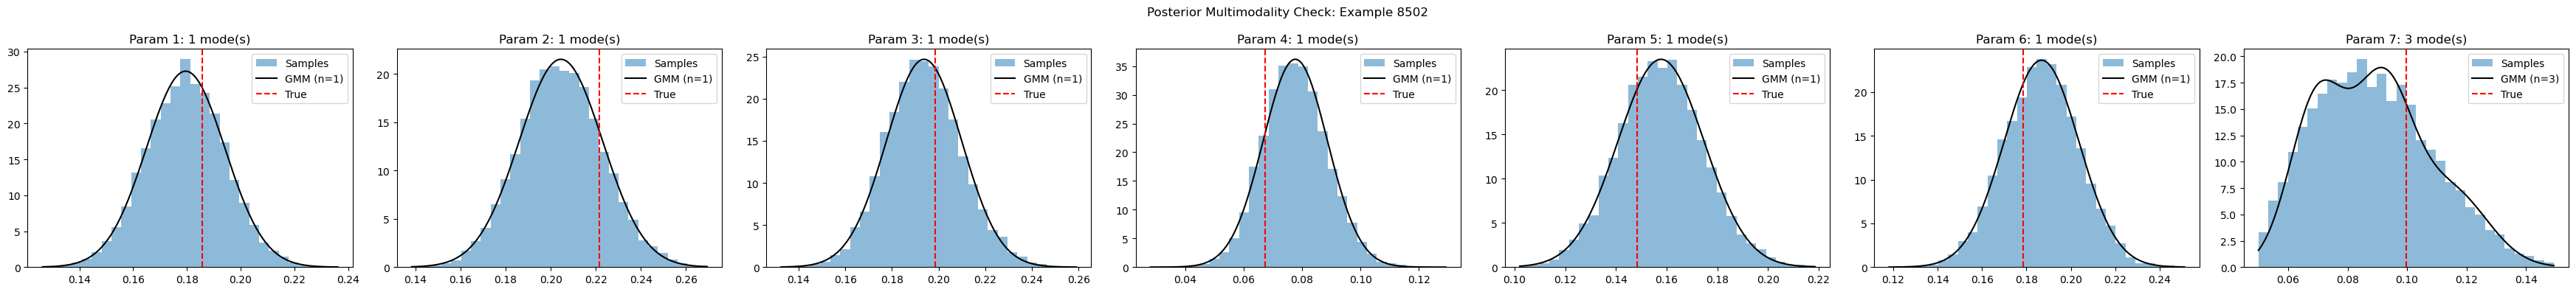

In [56]:
# 6. Mode Separation and Multimodality: Detect and visualize multimodal posteriors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

n_samples = 10000
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']

if val_x is not None and hasattr(trainer, 'posterior') and trainer.posterior is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    n_val, n_params = val_theta.shape
    n_examples = 5  # Number of validation examples to check
    rng = np.random.default_rng(0)
    idxs = rng.choice(n_val, size=n_examples, replace=False)
    for idx in idxs:
        obs = val_x_np[idx:idx+1]
        samples = trainer.posterior.sample((n_samples,), x=torch.tensor(obs, dtype=torch.float32))
        samples = samples.detach().cpu().numpy()
        # Fit a Gaussian Mixture Model to the samples for each parameter
        fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 4))
        if n_params == 1:
            axes = [axes]
        for j in range(n_params):
            param_samples = samples[:, j].reshape(-1, 1)
            bic = []
            for n_components in range(1, 4):
                gmm = GaussianMixture(n_components=n_components, random_state=0)
                gmm.fit(param_samples)
                bic.append(gmm.bic(param_samples))
            best_n = np.argmin(bic) + 1
            best_gmm = GaussianMixture(n_components=best_n, random_state=0).fit(param_samples)
            x_grid = np.linspace(param_samples.min(), param_samples.max(), 200).reshape(-1, 1)
            logprob = best_gmm.score_samples(x_grid)
            axes[j].hist(param_samples, bins=30, density=True, alpha=0.5, label='Samples')
            axes[j].plot(x_grid, np.exp(logprob), 'k-', label=f'GMM (n={best_n})')
            axes[j].axvline(val_theta[idx, j], color='red', linestyle='--', label='True')
            axes[j].set_title(f'Param {j+1}: {best_n} mode(s)')
            axes[j].legend()
        plt.suptitle(f'Posterior Multimodality Check: Example {idx}')
        plt.tight_layout()
        plt.show()
else:
    print('Posterior or validation data not found for multimodality analysis.')